In [155]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [156]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [157]:
def model(t_u, w0, w1, b):
    return w0 * t_u**2 + w1 * t_u + b

In [158]:
def loss_fn(predicted, actual):
    squared_diffs = (predicted - actual)**2
    return squared_diffs.mean()

In [159]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [160]:
# Validate that the the new model is working

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

In [161]:
# Does zeroing the optimizer gradient at the begining make a difference 

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

In [162]:
# Significance of T_un

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

In [163]:
# Significance of T_un with zero gradient

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

## final setup

In [164]:
rates_to_learn_at = [1/x for x in [10, 100, 1000, 10000, 100000]]
rates_to_learn_at

[0.1, 0.01, 0.001, 0.0001, 1e-05]

In [165]:
def training_loop(n_epochs, optimizer, params, t_u, t_c, epoch_report_val = 500):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        if epoch % epoch_report_val == 0:
            print(f'    Epoch {epoch}, Loss {float(loss)}')
            
    return params

## Deciding which optimizer to use

In [166]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = rates_to_learn_at[3]
optimizer = optim.SGD([params], lr=learning_rate) 

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, 
    t_u = t_un,
    t_c = t_c)

    Epoch 500, Loss 10.708596229553223
    Epoch 1000, Loss 8.642083168029785
    Epoch 1500, Loss 7.1710052490234375
    Epoch 2000, Loss 6.123476982116699
    Epoch 2500, Loss 5.377227306365967
    Epoch 3000, Loss 4.845284938812256
    Epoch 3500, Loss 4.465787887573242
    Epoch 4000, Loss 4.194724082946777
    Epoch 4500, Loss 4.0008015632629395
    Epoch 5000, Loss 3.8617441654205322


tensor([ 0.5570, -0.8881, -0.8753], requires_grad=True)

In [167]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = rates_to_learn_at[3]
optimizer = optim.Adam([params], lr=learning_rate) 

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, 
    t_c = t_c
    )

    Epoch 500, Loss 10577728.0
    Epoch 1000, Loss 9524402.0
    Epoch 1500, Loss 8545122.0
    Epoch 2000, Loss 7634292.5
    Epoch 2500, Loss 6787368.0
    Epoch 3000, Loss 6000706.0
    Epoch 3500, Loss 5271407.5
    Epoch 4000, Loss 4597170.0
    Epoch 4500, Loss 3976134.25
    Epoch 5000, Loss 3406753.75


tensor([ 0.5412,  0.5412, -0.4588], requires_grad=True)

Best model is subjective but loss seems to be better with SGD with higher optimizers

## View Output Function

In [168]:
from matplotlib import pyplot as plt

def graph_temp(model, params, t_u, t_c, title:str):
    t_range = torch.arange(20., 85., .1).unsqueeze(1)
 
        
    fig = plt.figure(dpi=600)
    plt.title(title)
    plt.xlabel("Fahrenheit")
    plt.ylabel("Celsius")
    plt.plot(t_u.numpy(), t_c.numpy(), 'o')
    plt.plot(t_range.numpy(), model(0.1*t_range, *params).detach().numpy(), 'c-')
    plt.plot(t_u.numpy(), model(0.1 * t_u, *params).detach().numpy(), 'kx')


## Training loop at different learning rates

In [169]:
initial_paramaters = [0.05, 2, 1.0]

### SGD

  Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

  Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

  Learning rate is 0.001 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epo

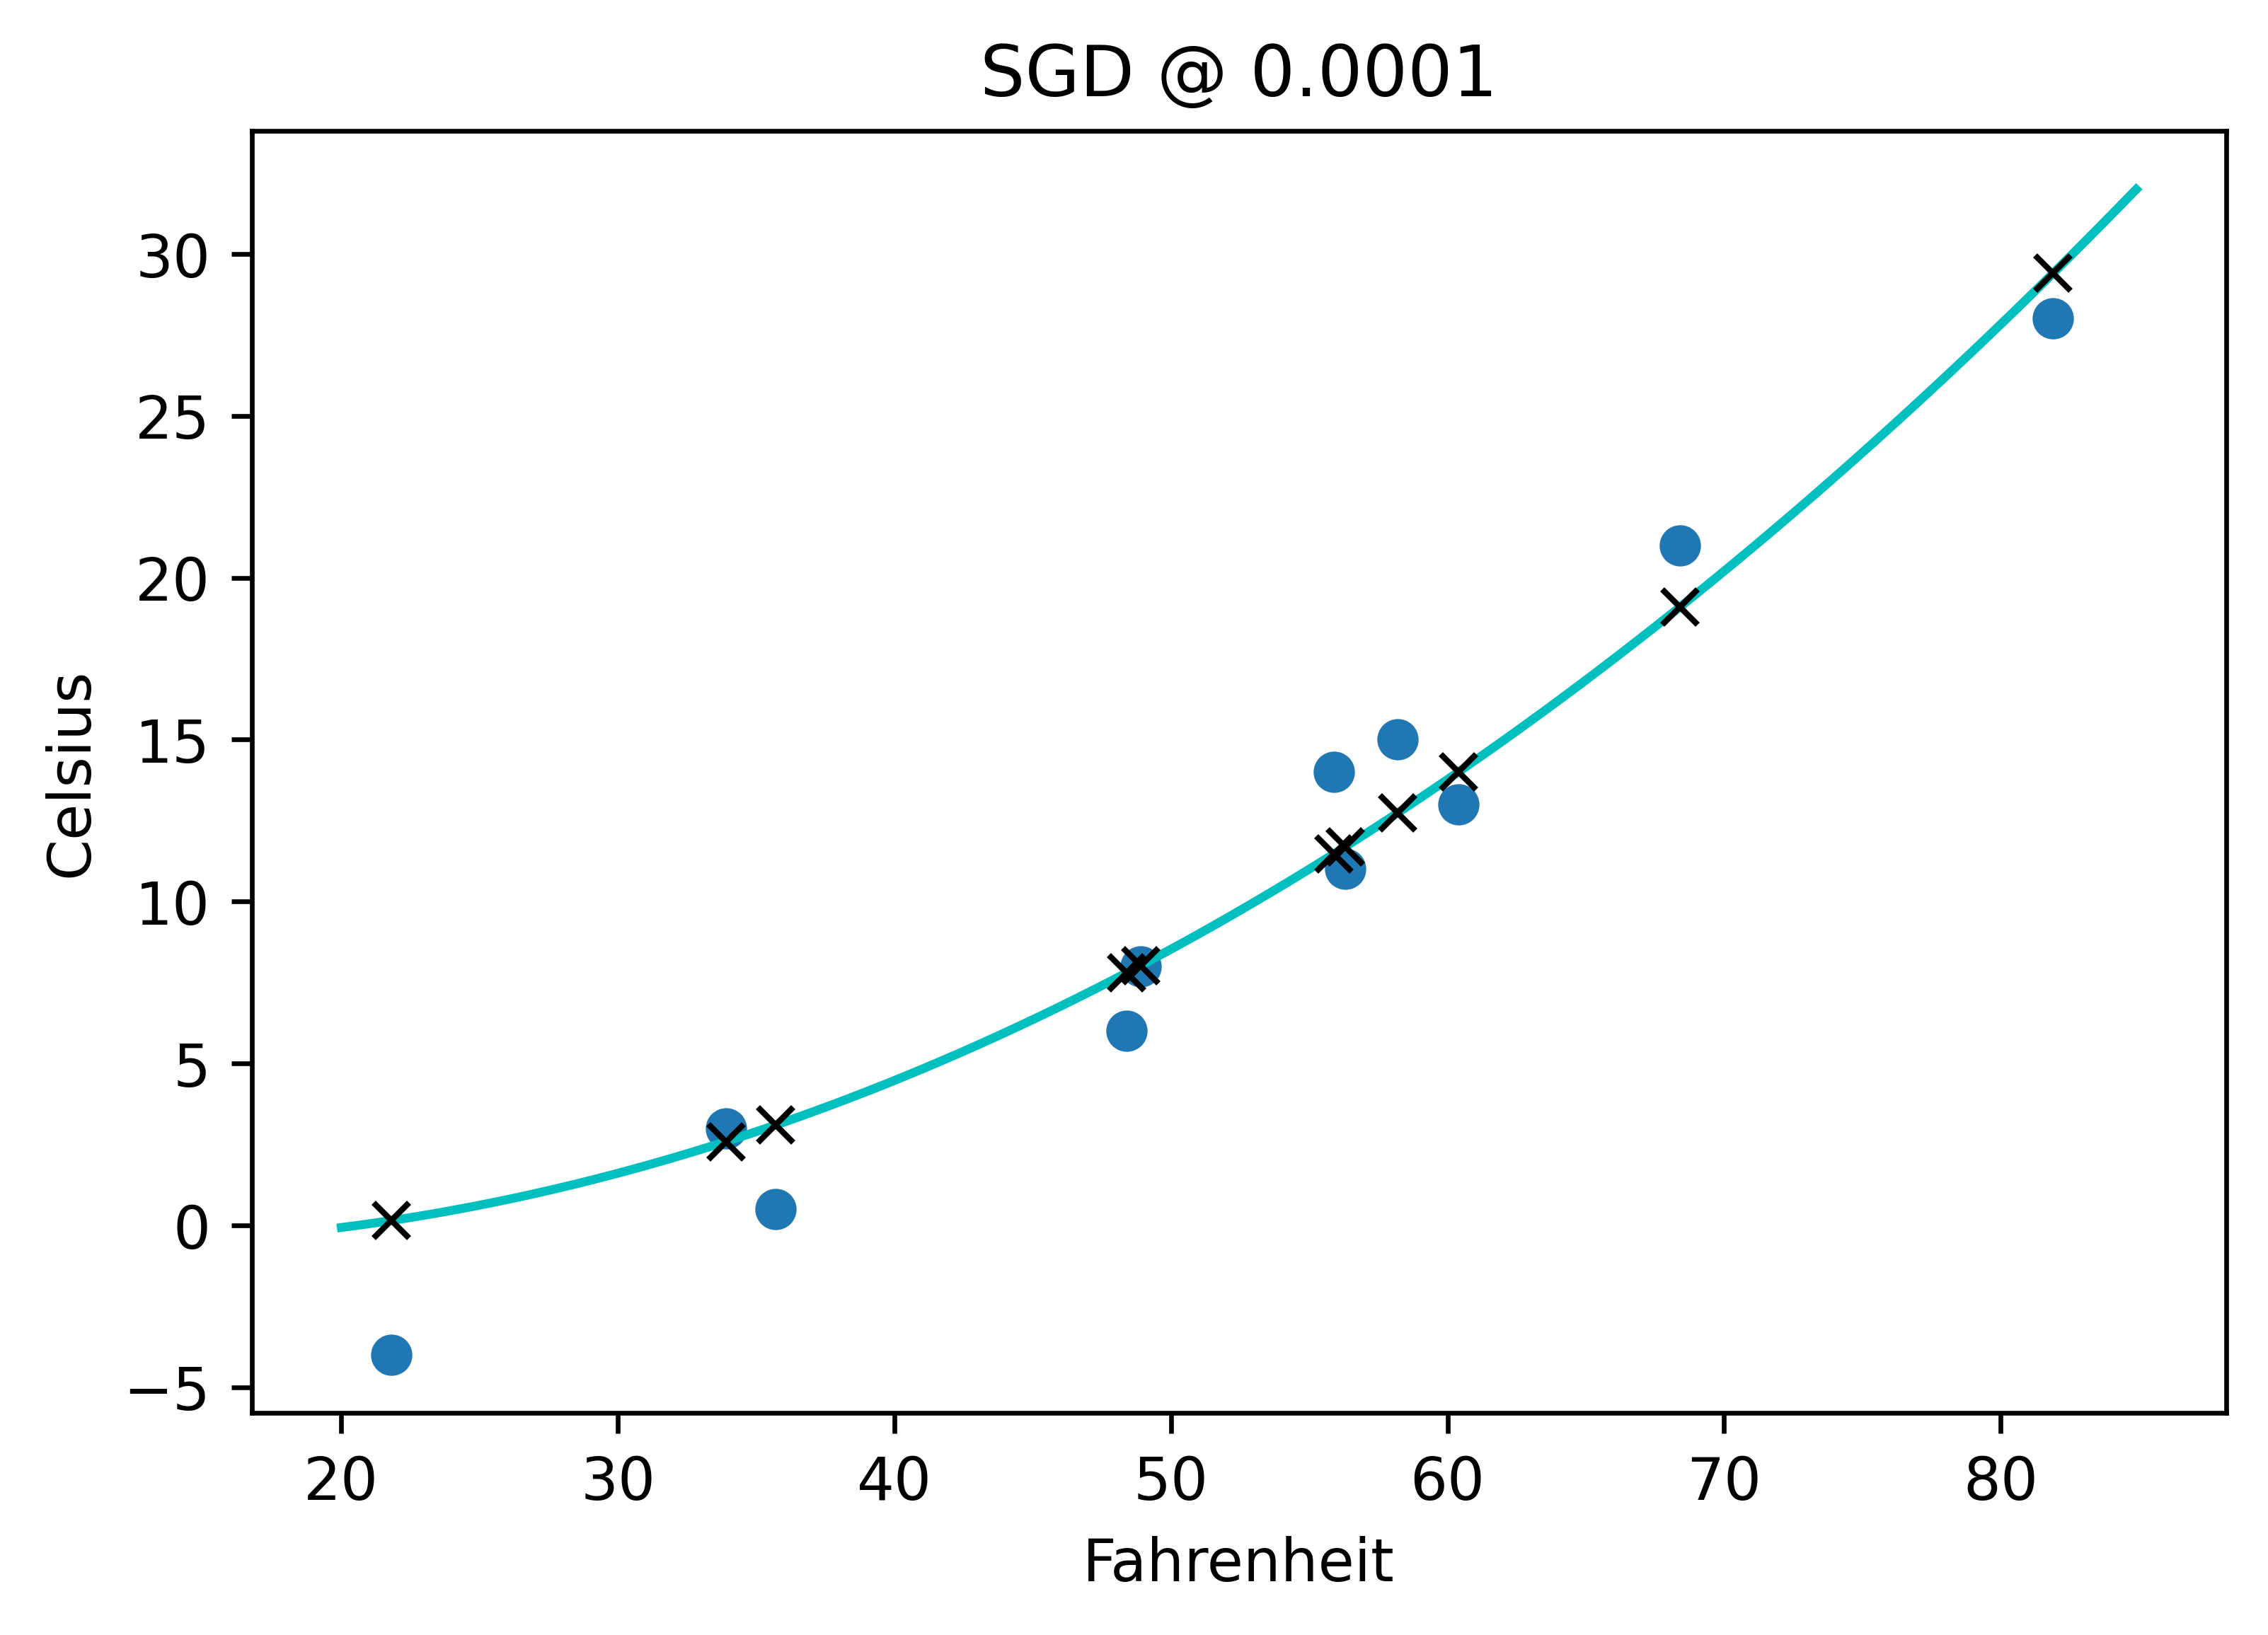

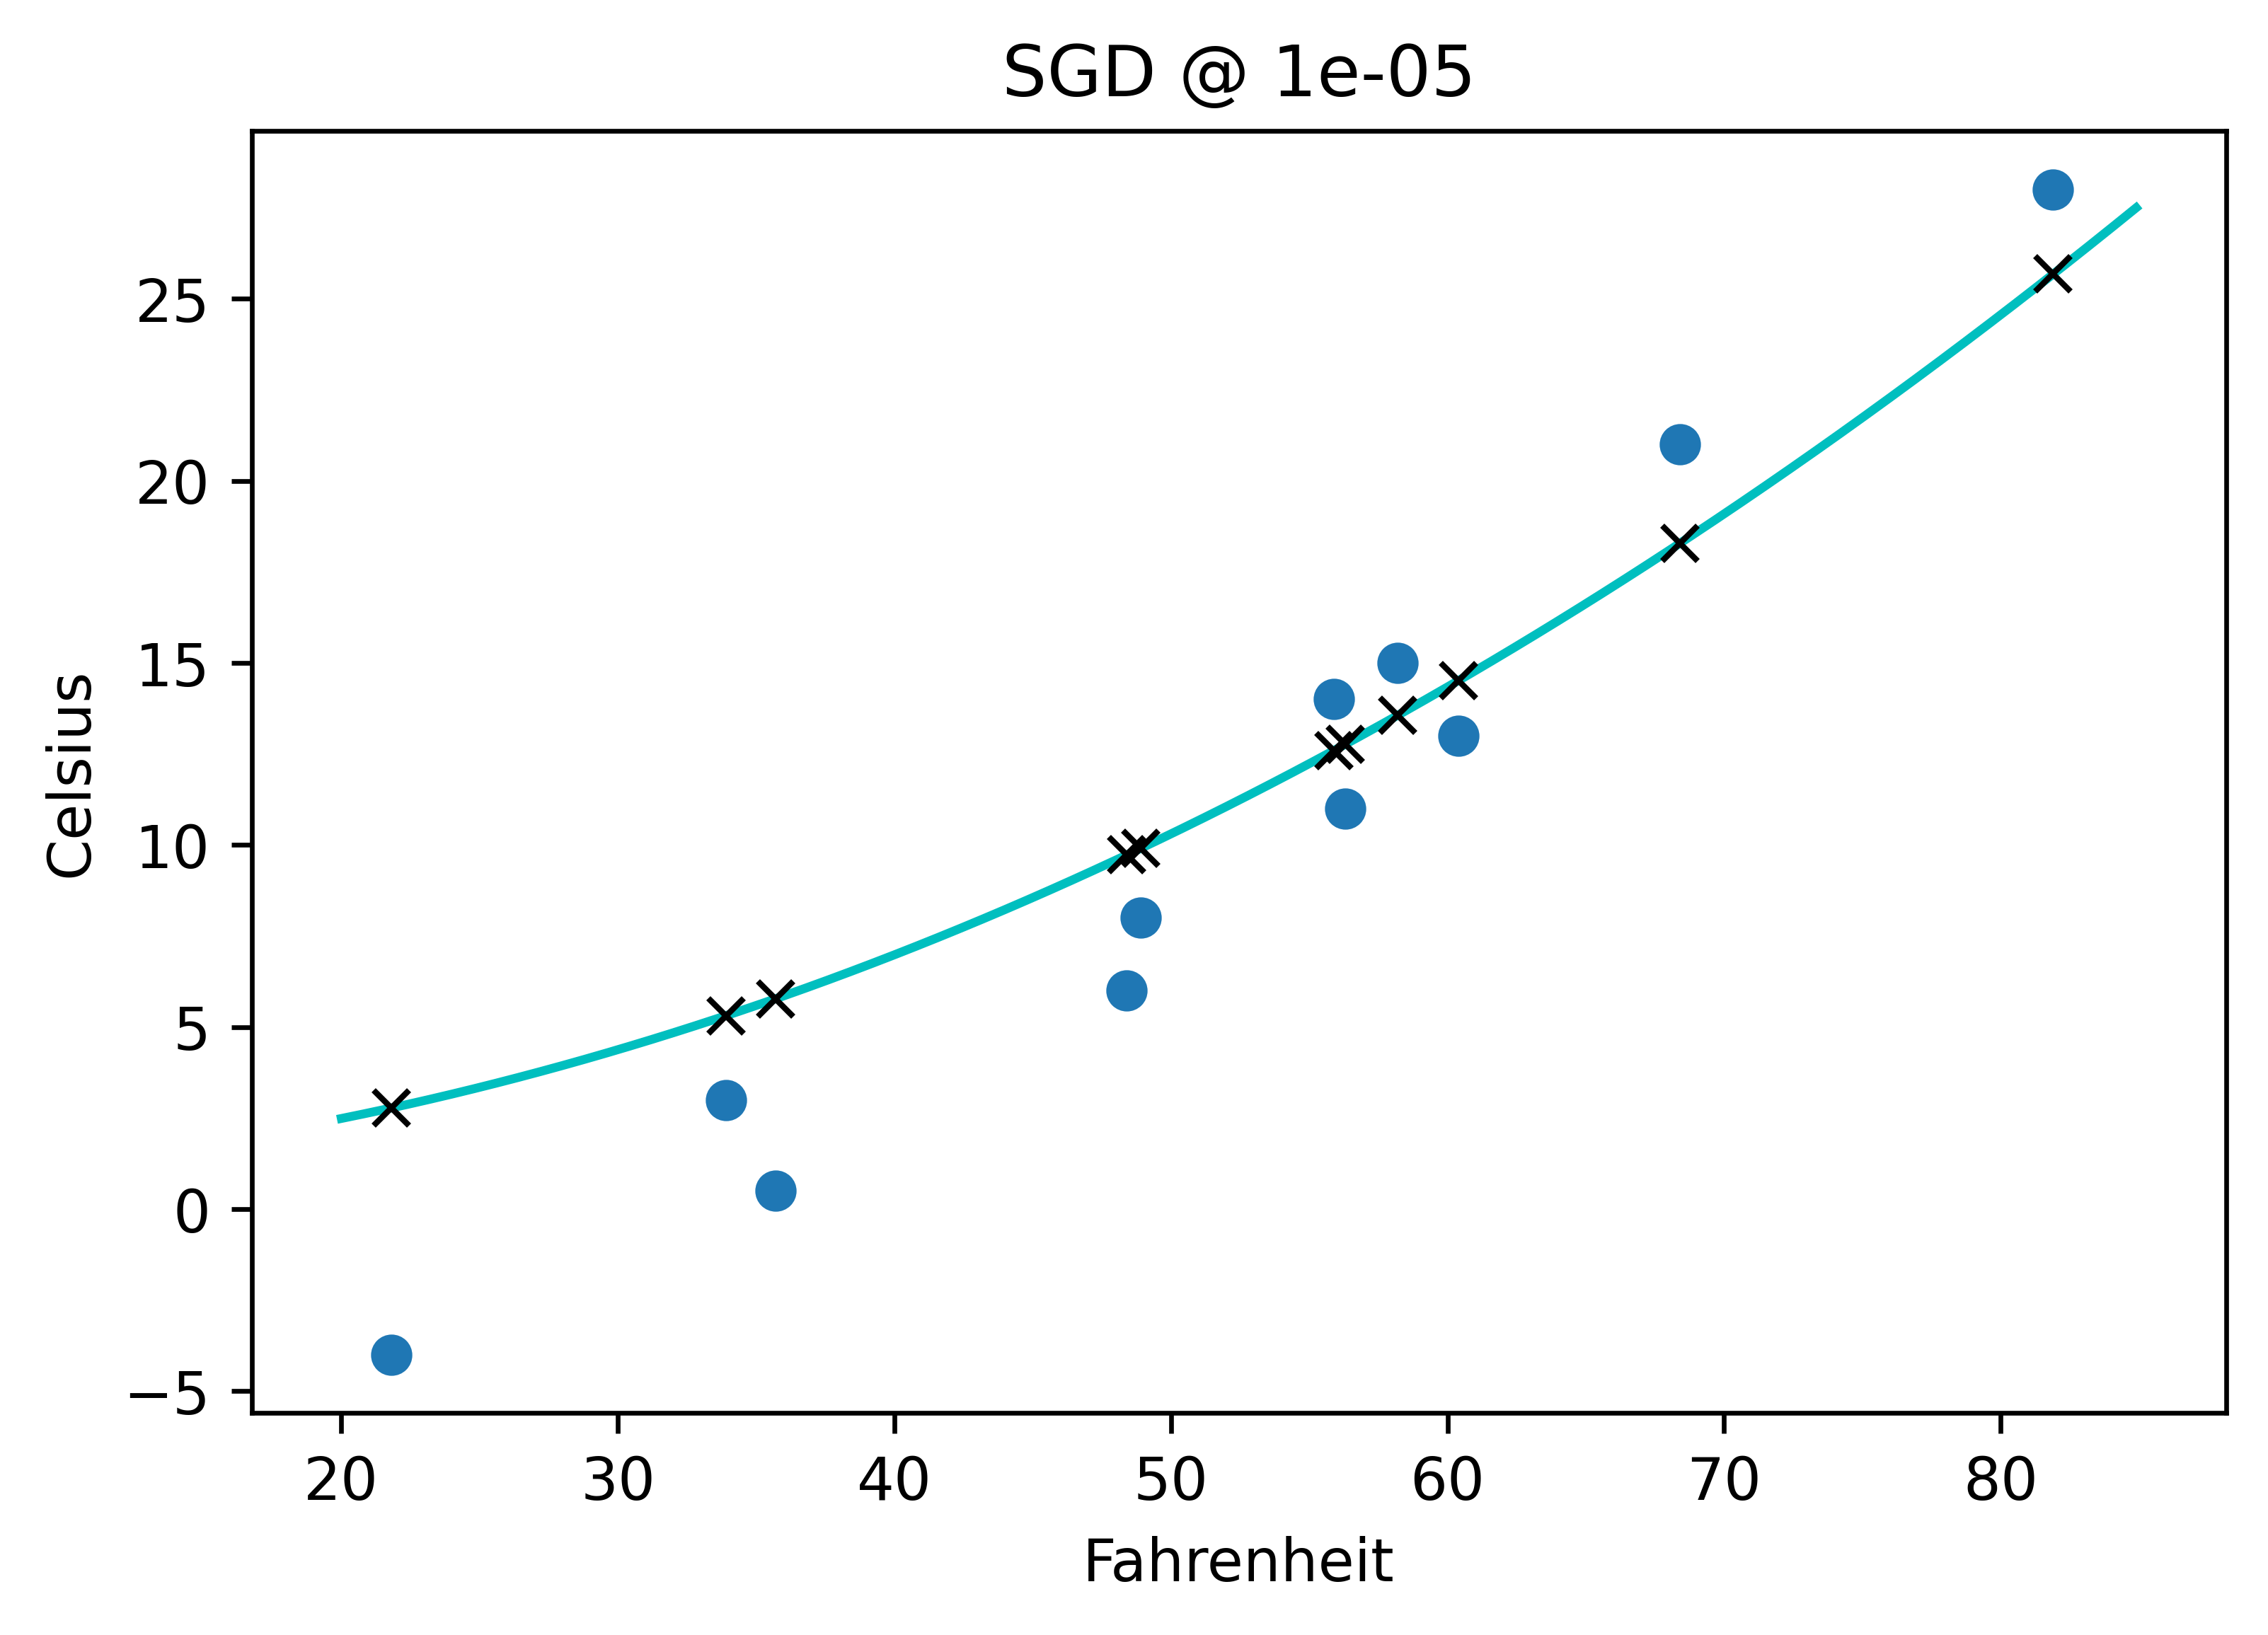

In [170]:
for rate in rates_to_learn_at:
    print(f"  Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.SGD([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"SGD @ {rate}")
    
    print('\n'+"--"*30+'\n')

### ADAM

Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 2.58184552192688
    Epoch 1000, Loss 2.182008743286133
    Epoch 1500, Loss 2.0979459285736084
    Epoch 2000, Loss 2.090930223464966
    Epoch 2500, Loss 2.0907227993011475
    Epoch 3000, Loss 2.0907208919525146
    Epoch 3500, Loss 2.1527254581451416
    Epoch 4000, Loss 2.0907206535339355
    Epoch 4500, Loss 2.090726375579834
    Epoch 5000, Loss 2.386545419692993
Final Paramaters: tensor([  0.2954,   2.4884, -10.6376], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 3.854214668273926
    Epoch 1000, Loss 3.084385871887207
    Epoch 1500, Loss 2.946929931640625
    Epoch 2000, Loss 2.789891481399536
    Epoch 2500, Loss 2.624614953994751
    Epoch 3000, Loss 2.4659945964813232
    Epoch 3500, Loss 2.328519582748413
    Epoch 4000, Loss 2.2228968143463135
    Epoch 4500, Loss 2.1528849601745605
    E

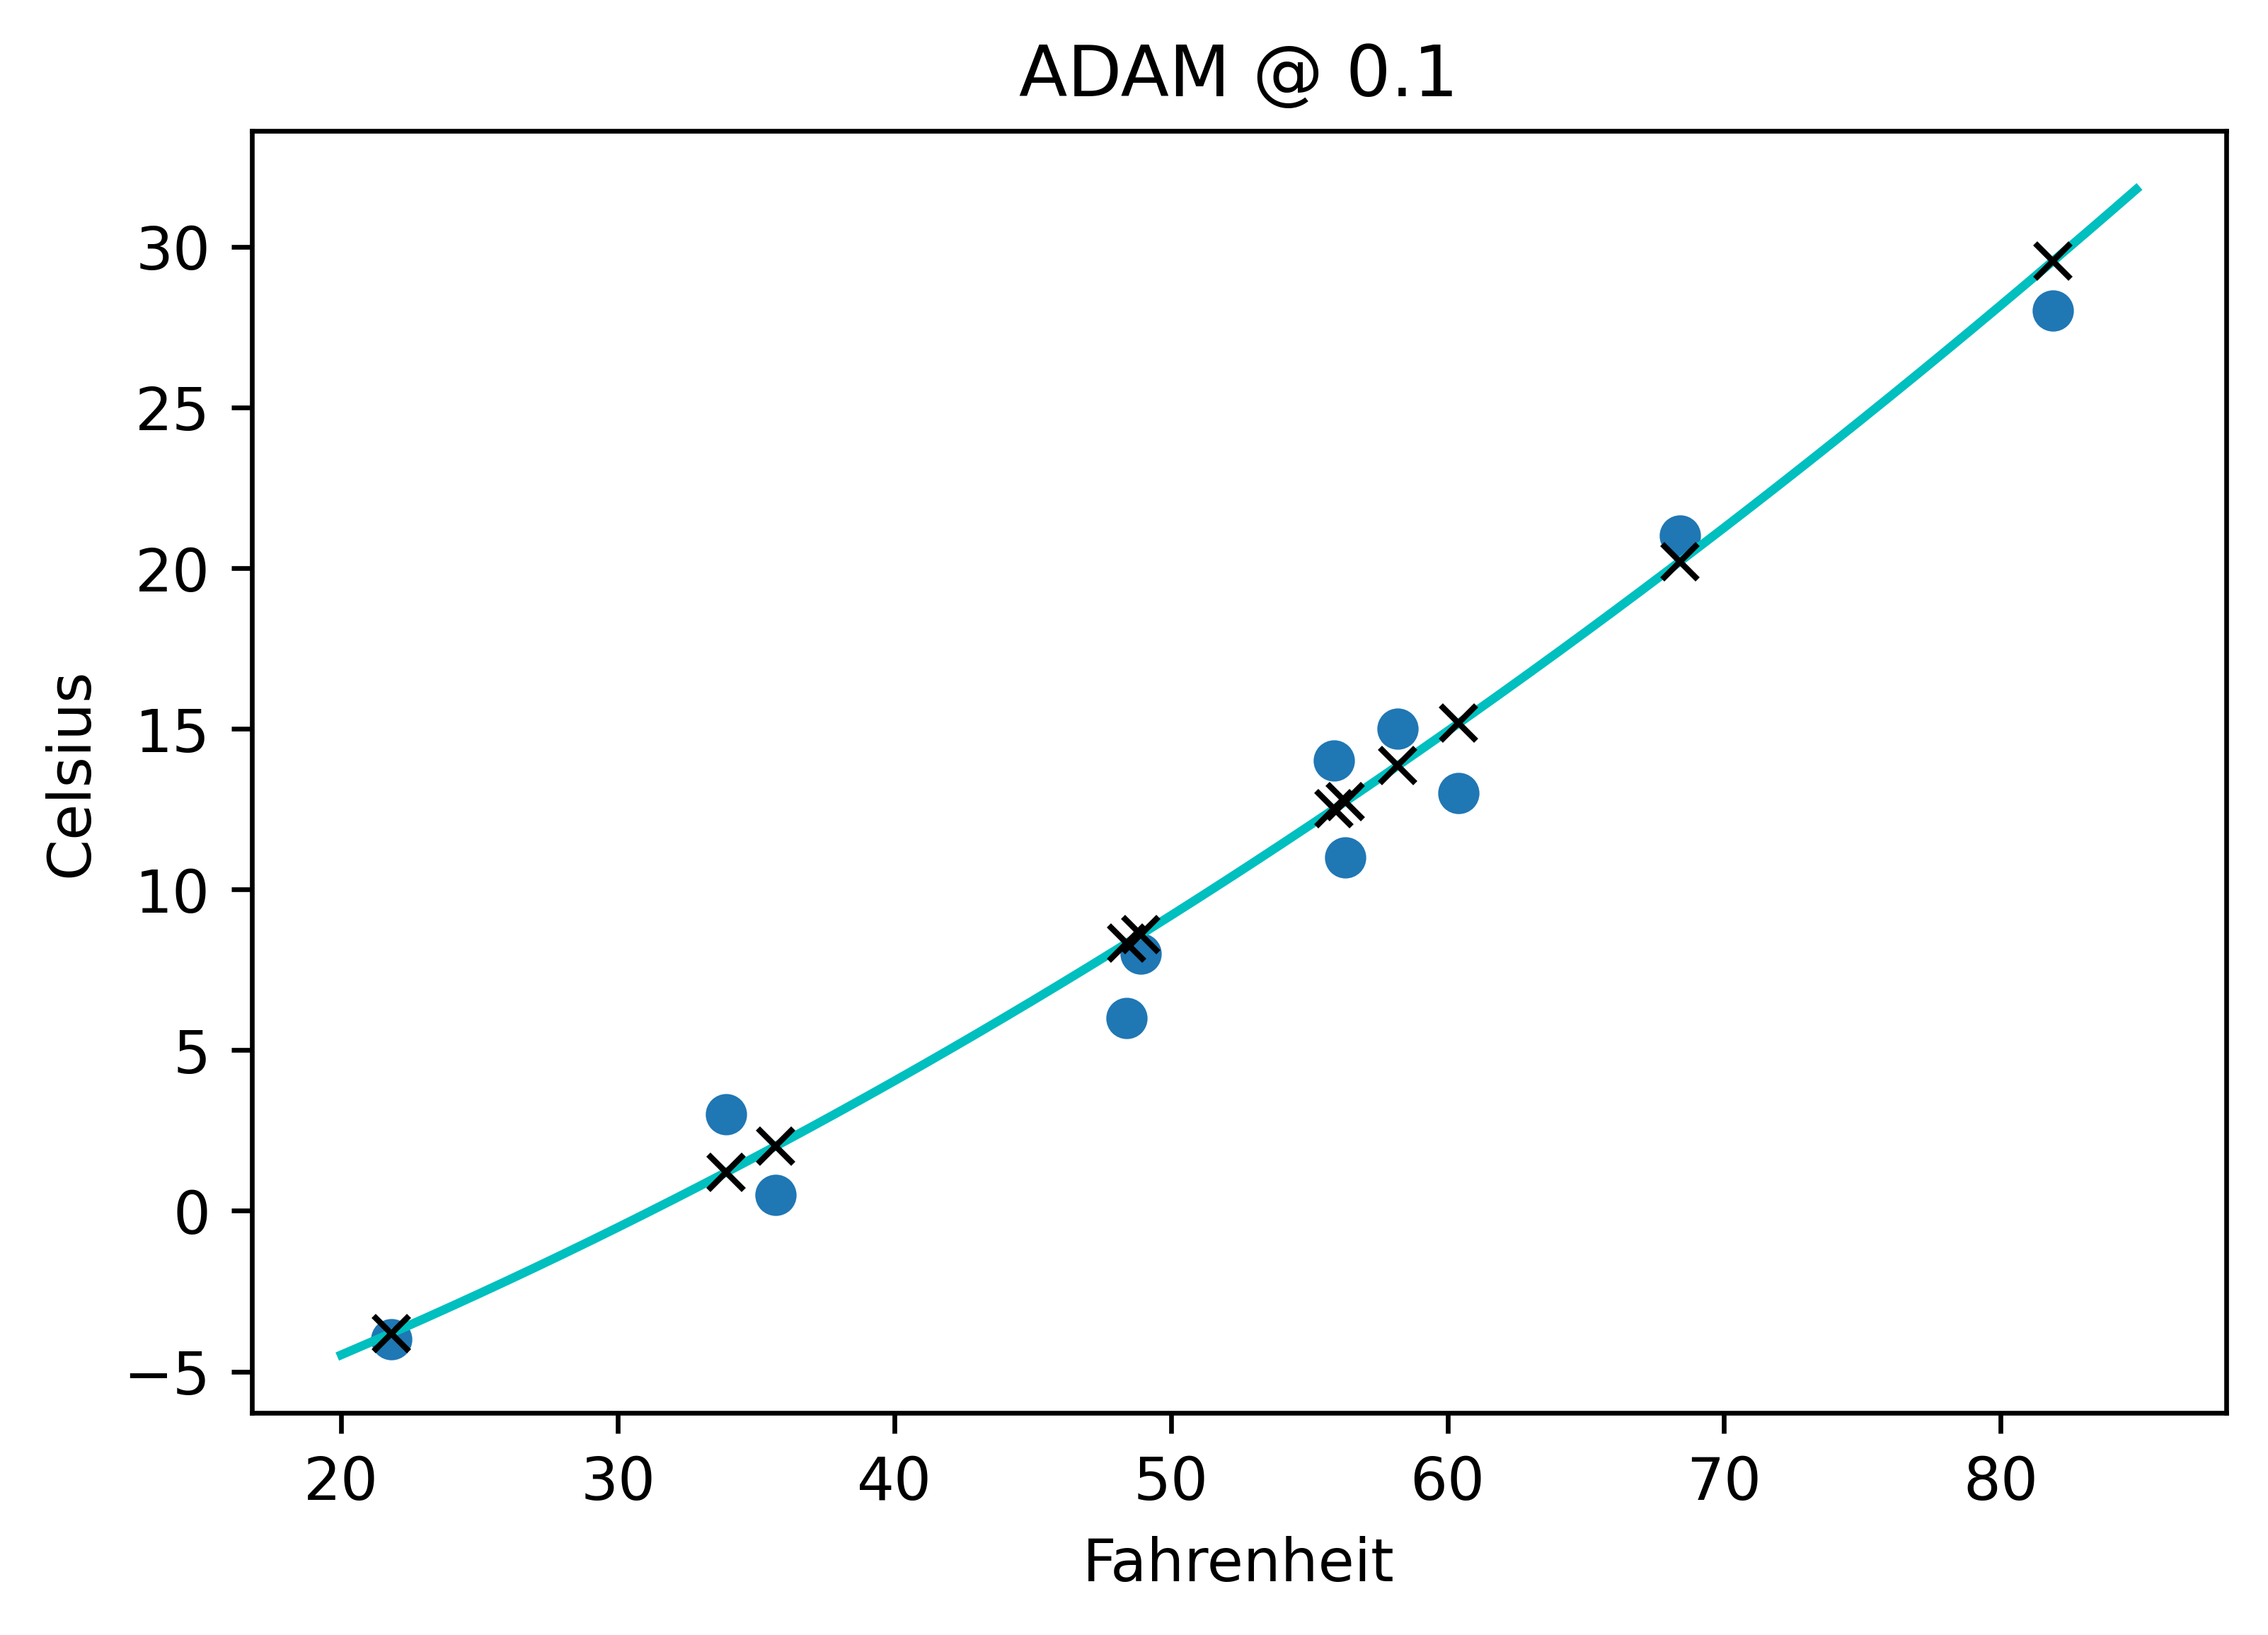

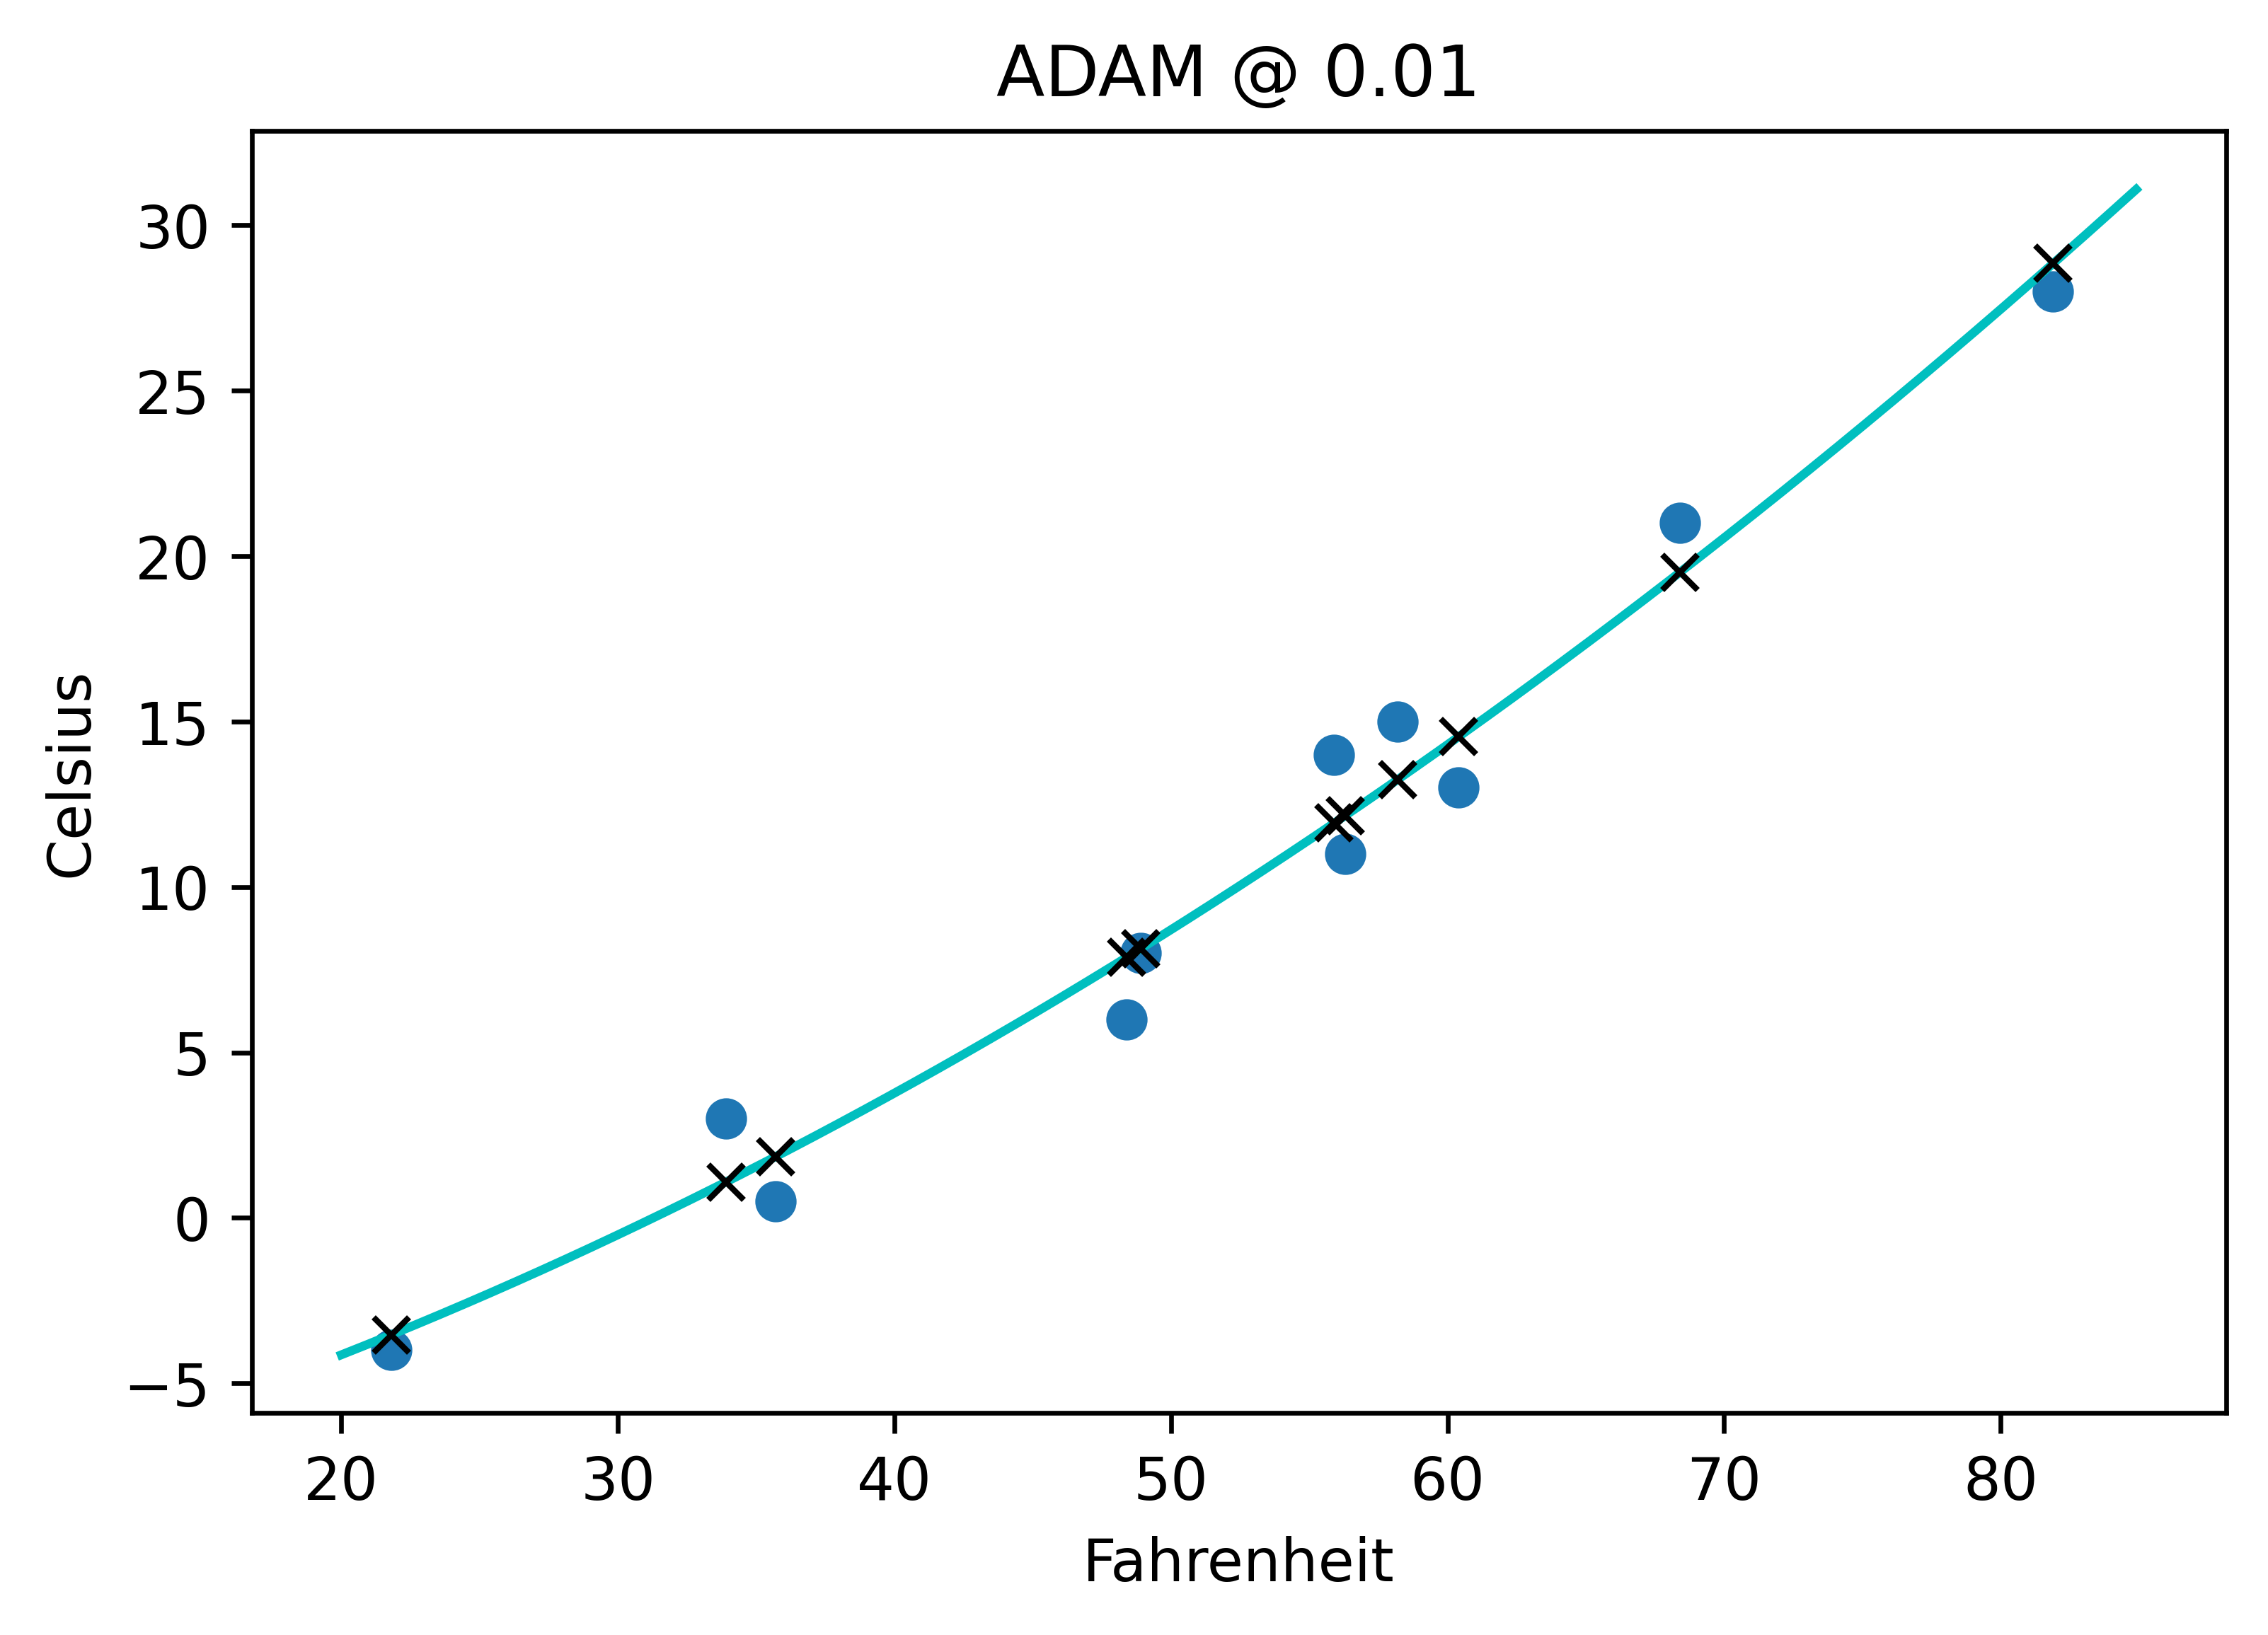

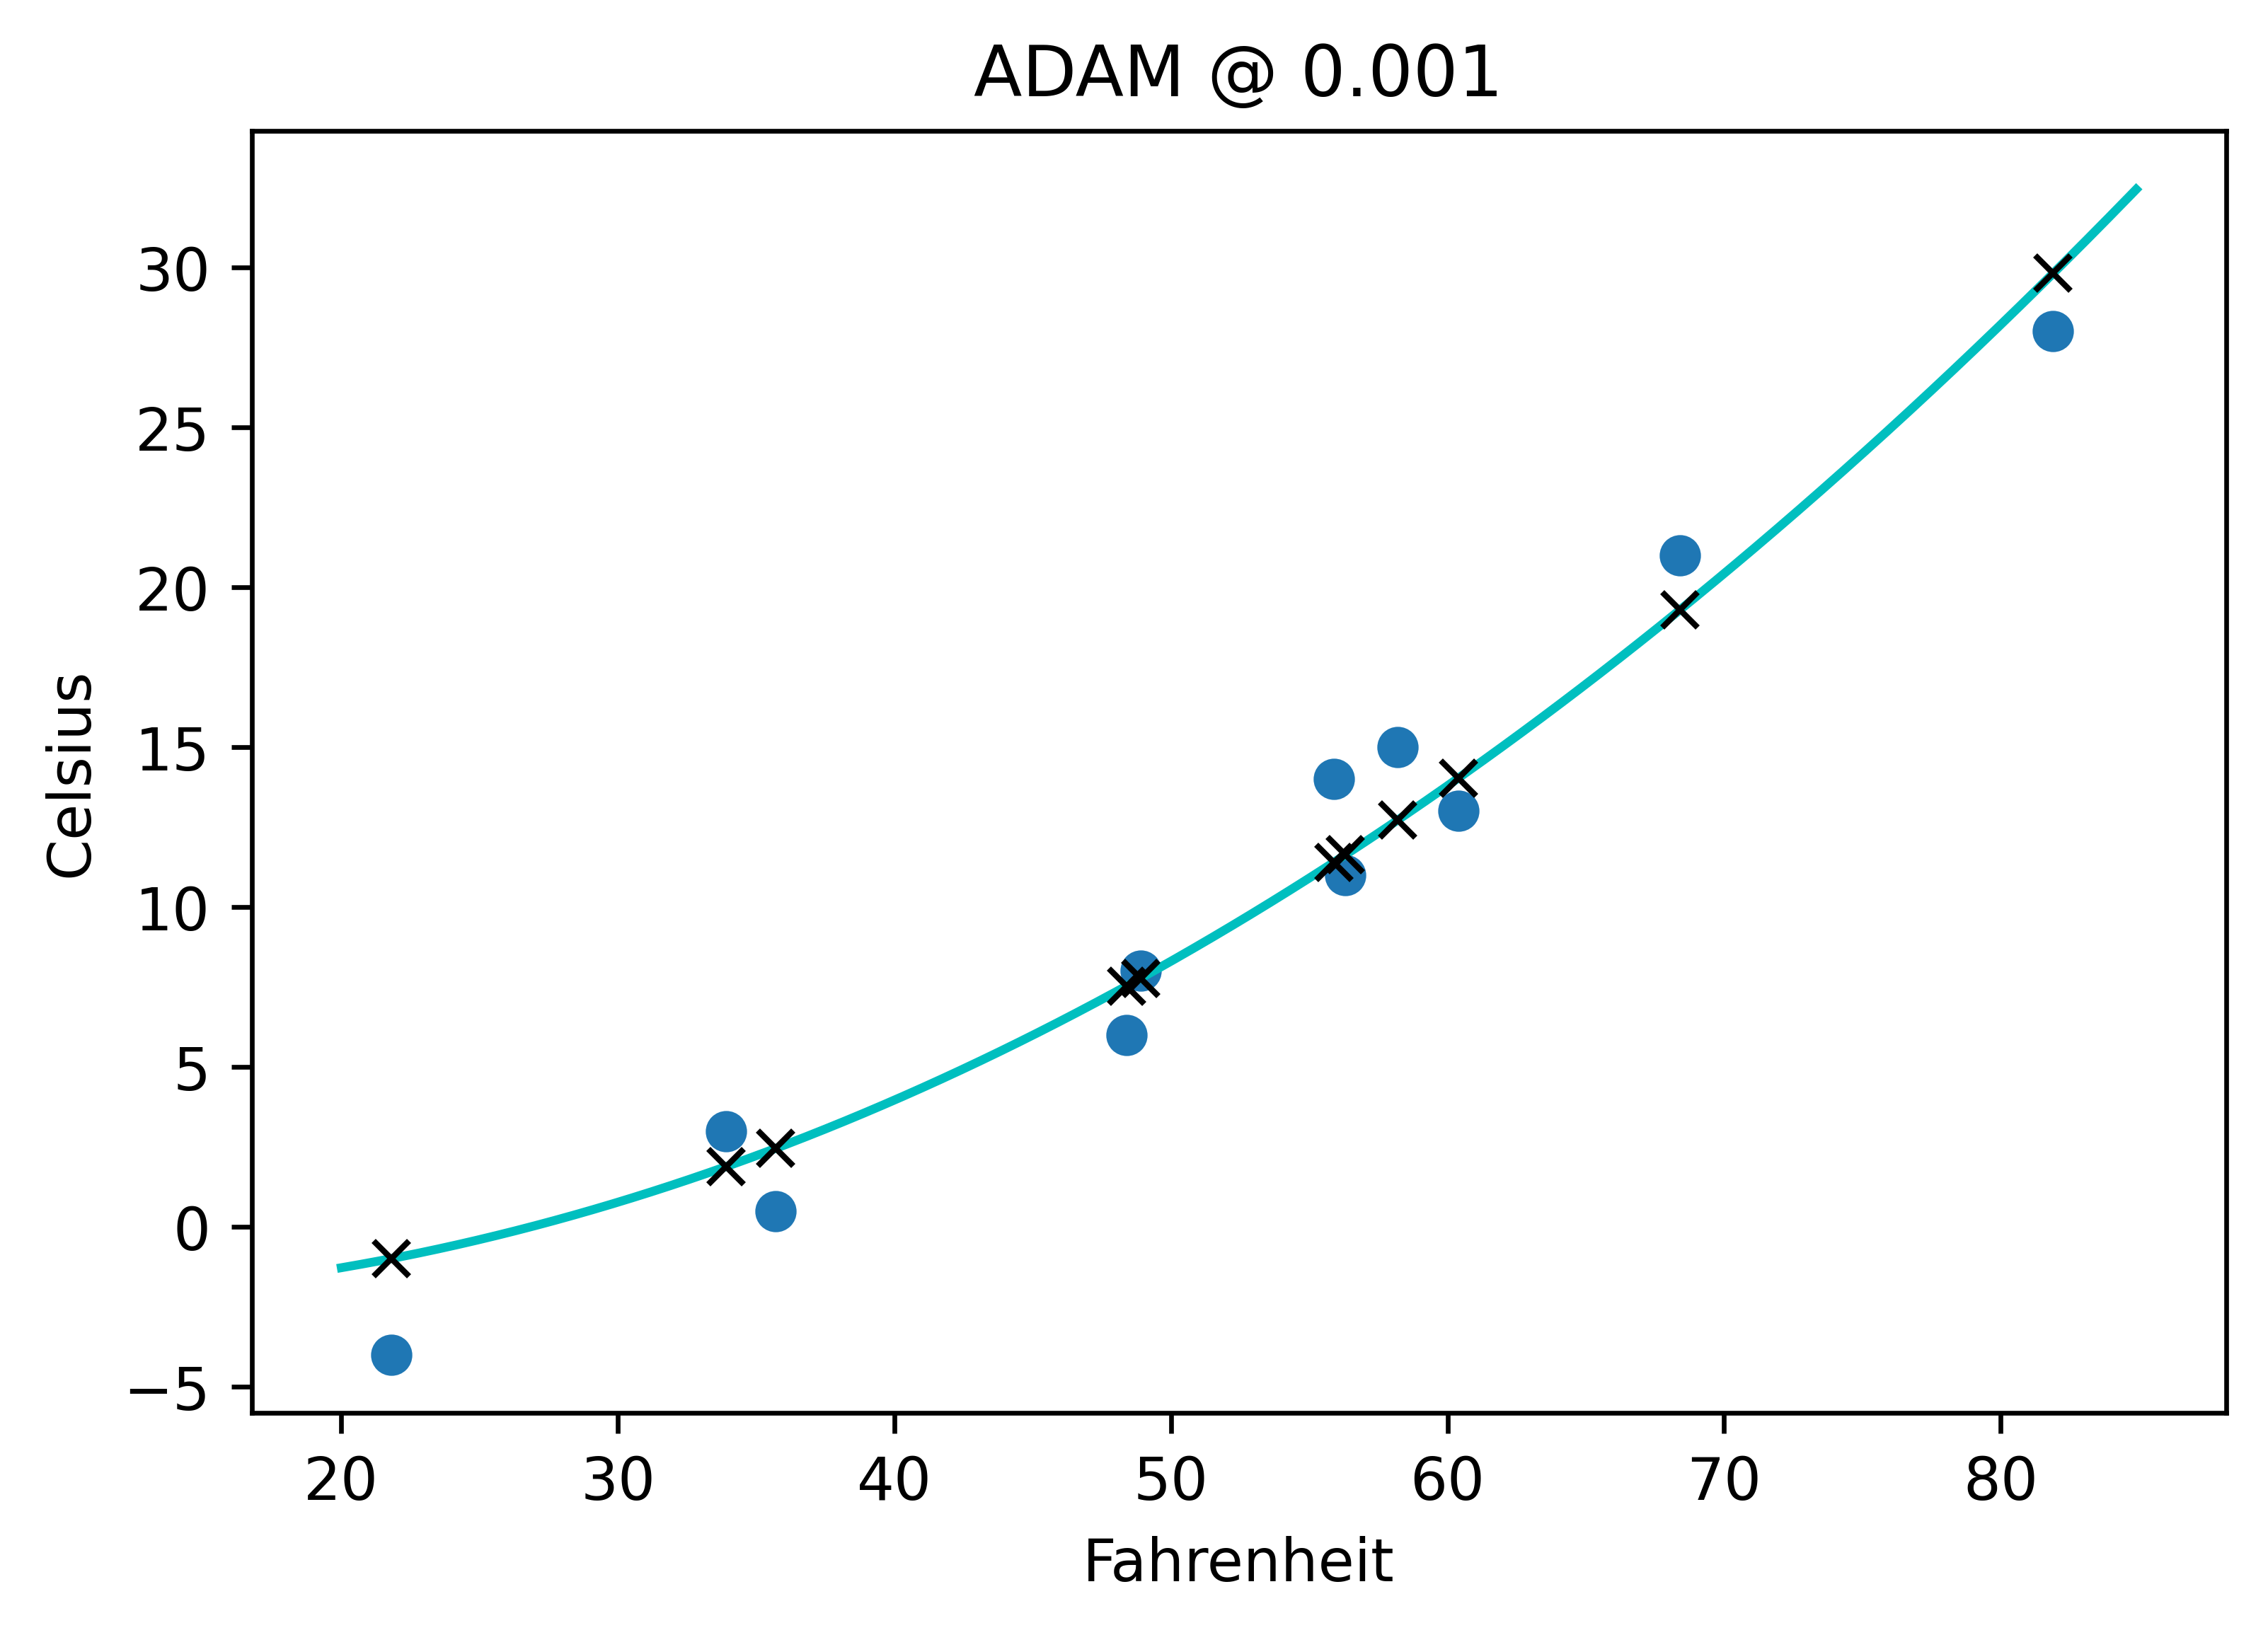

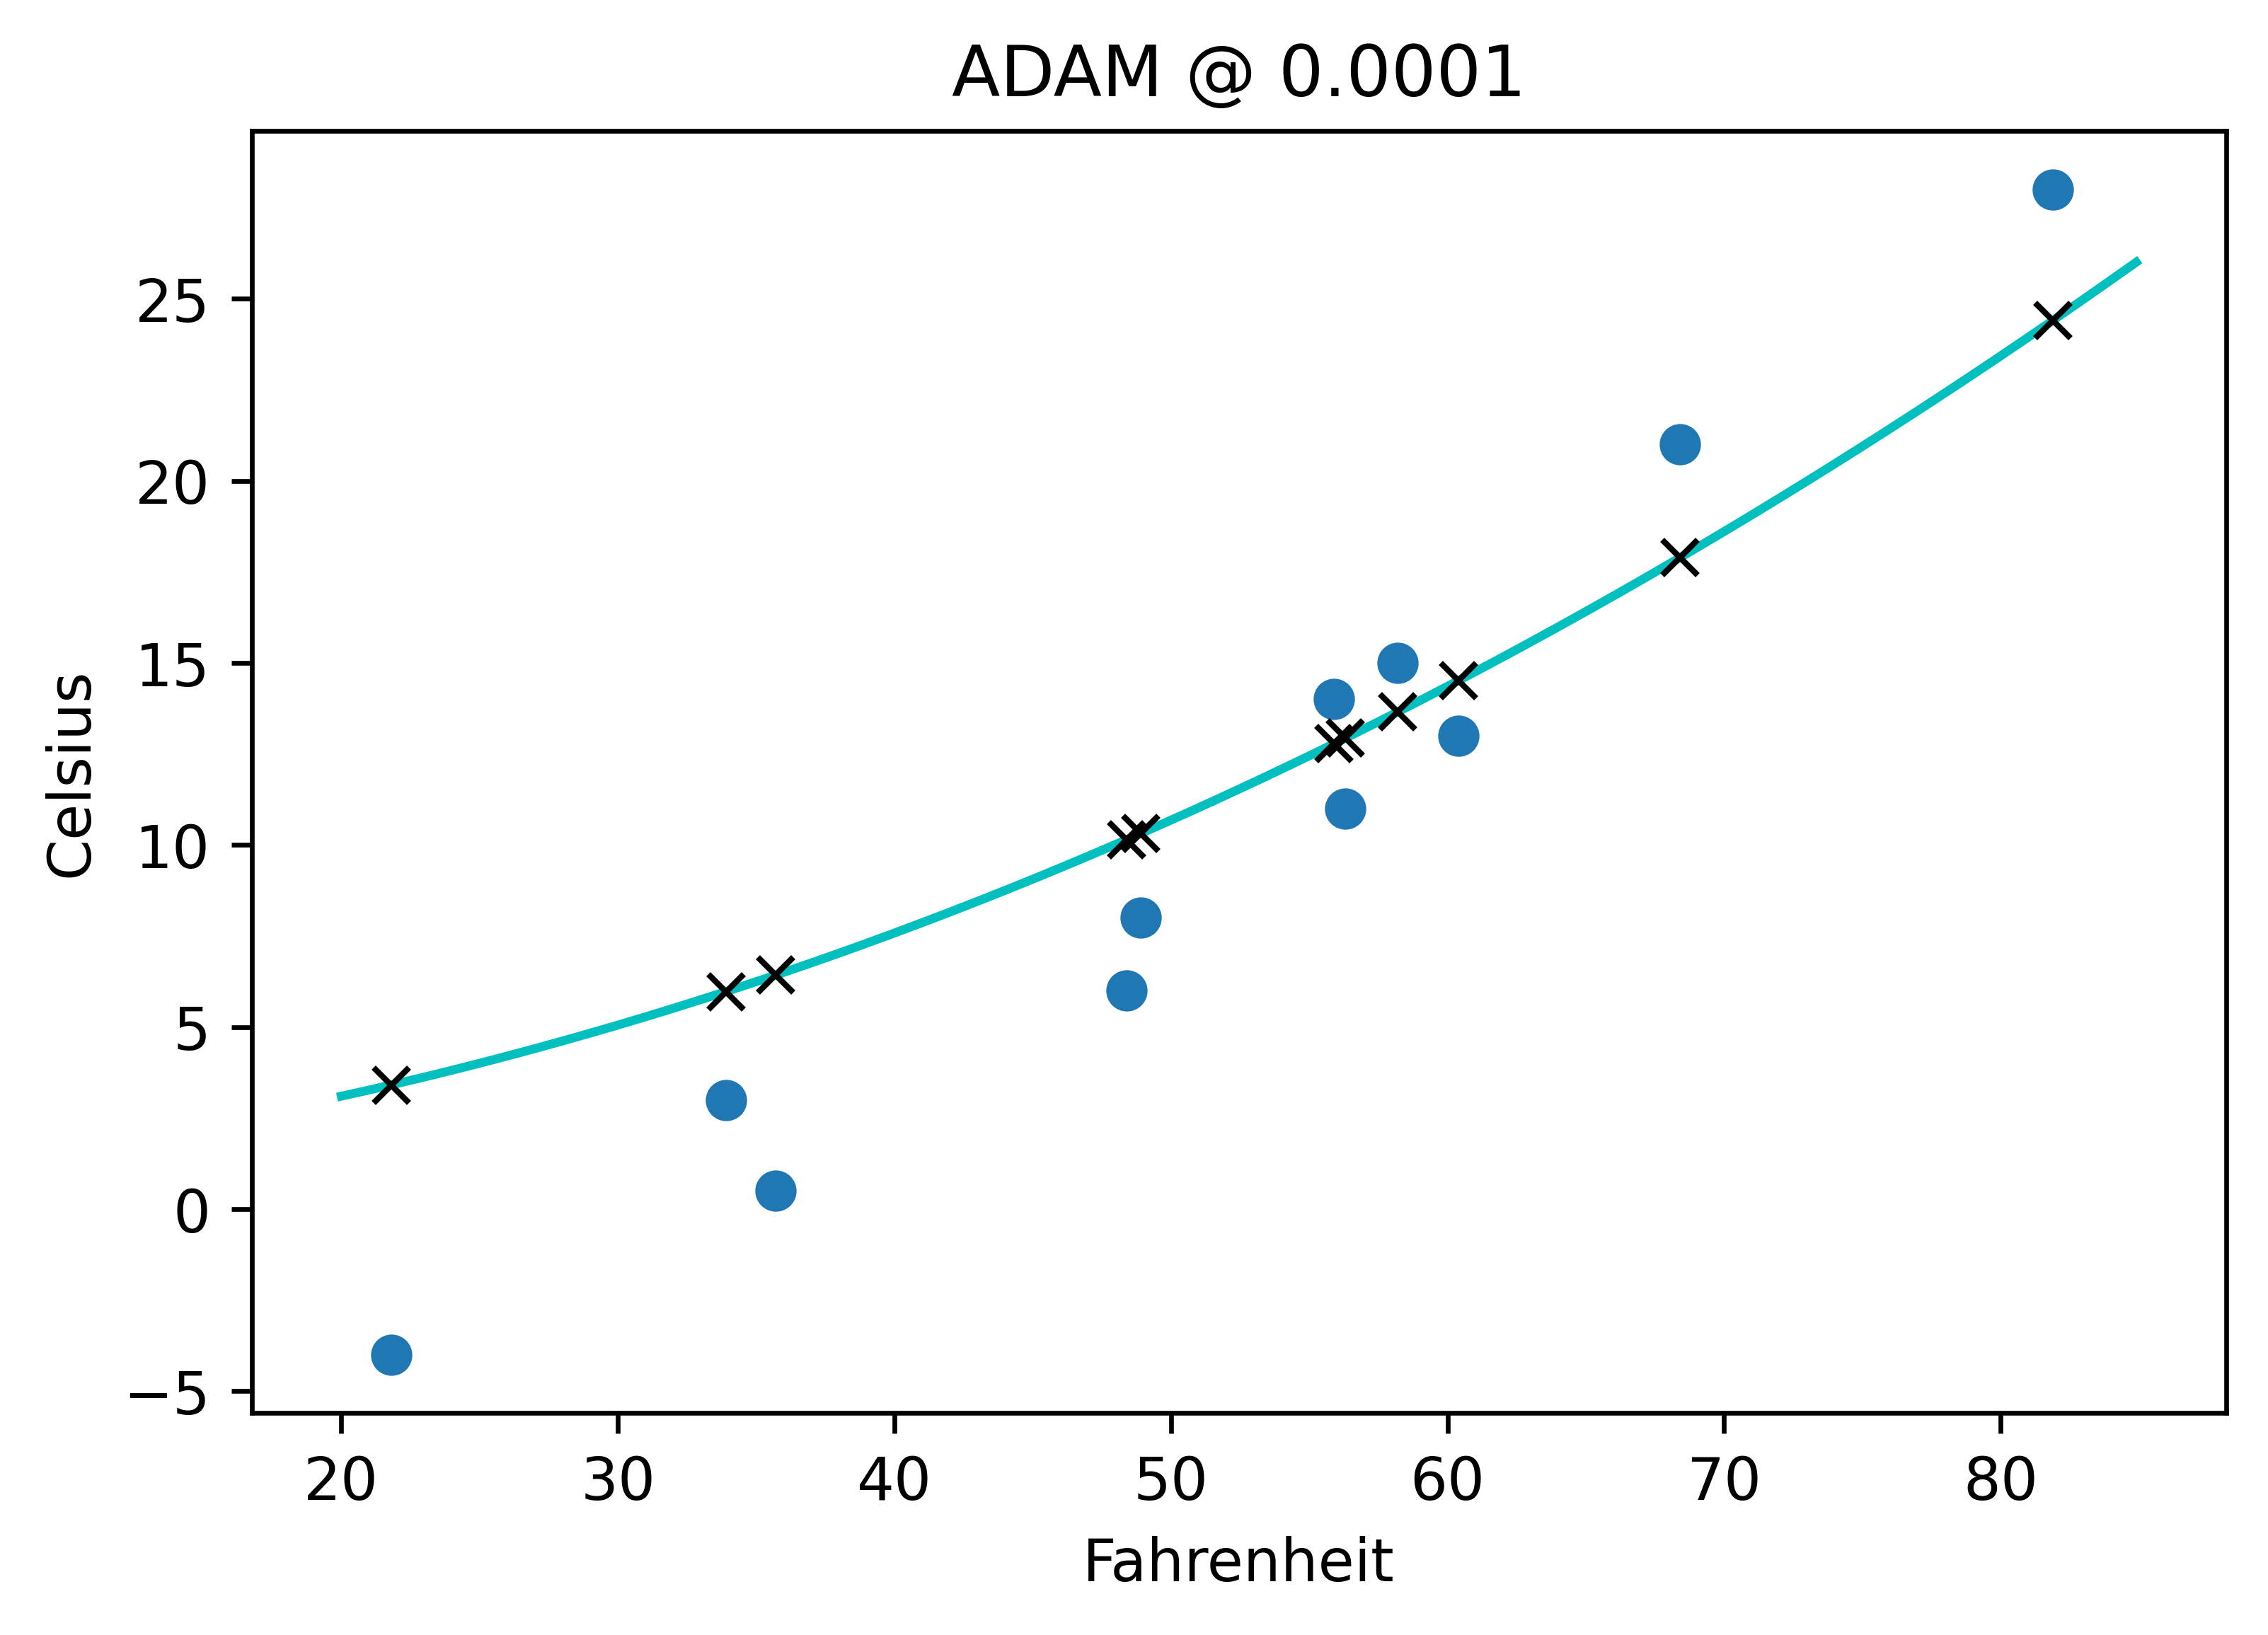

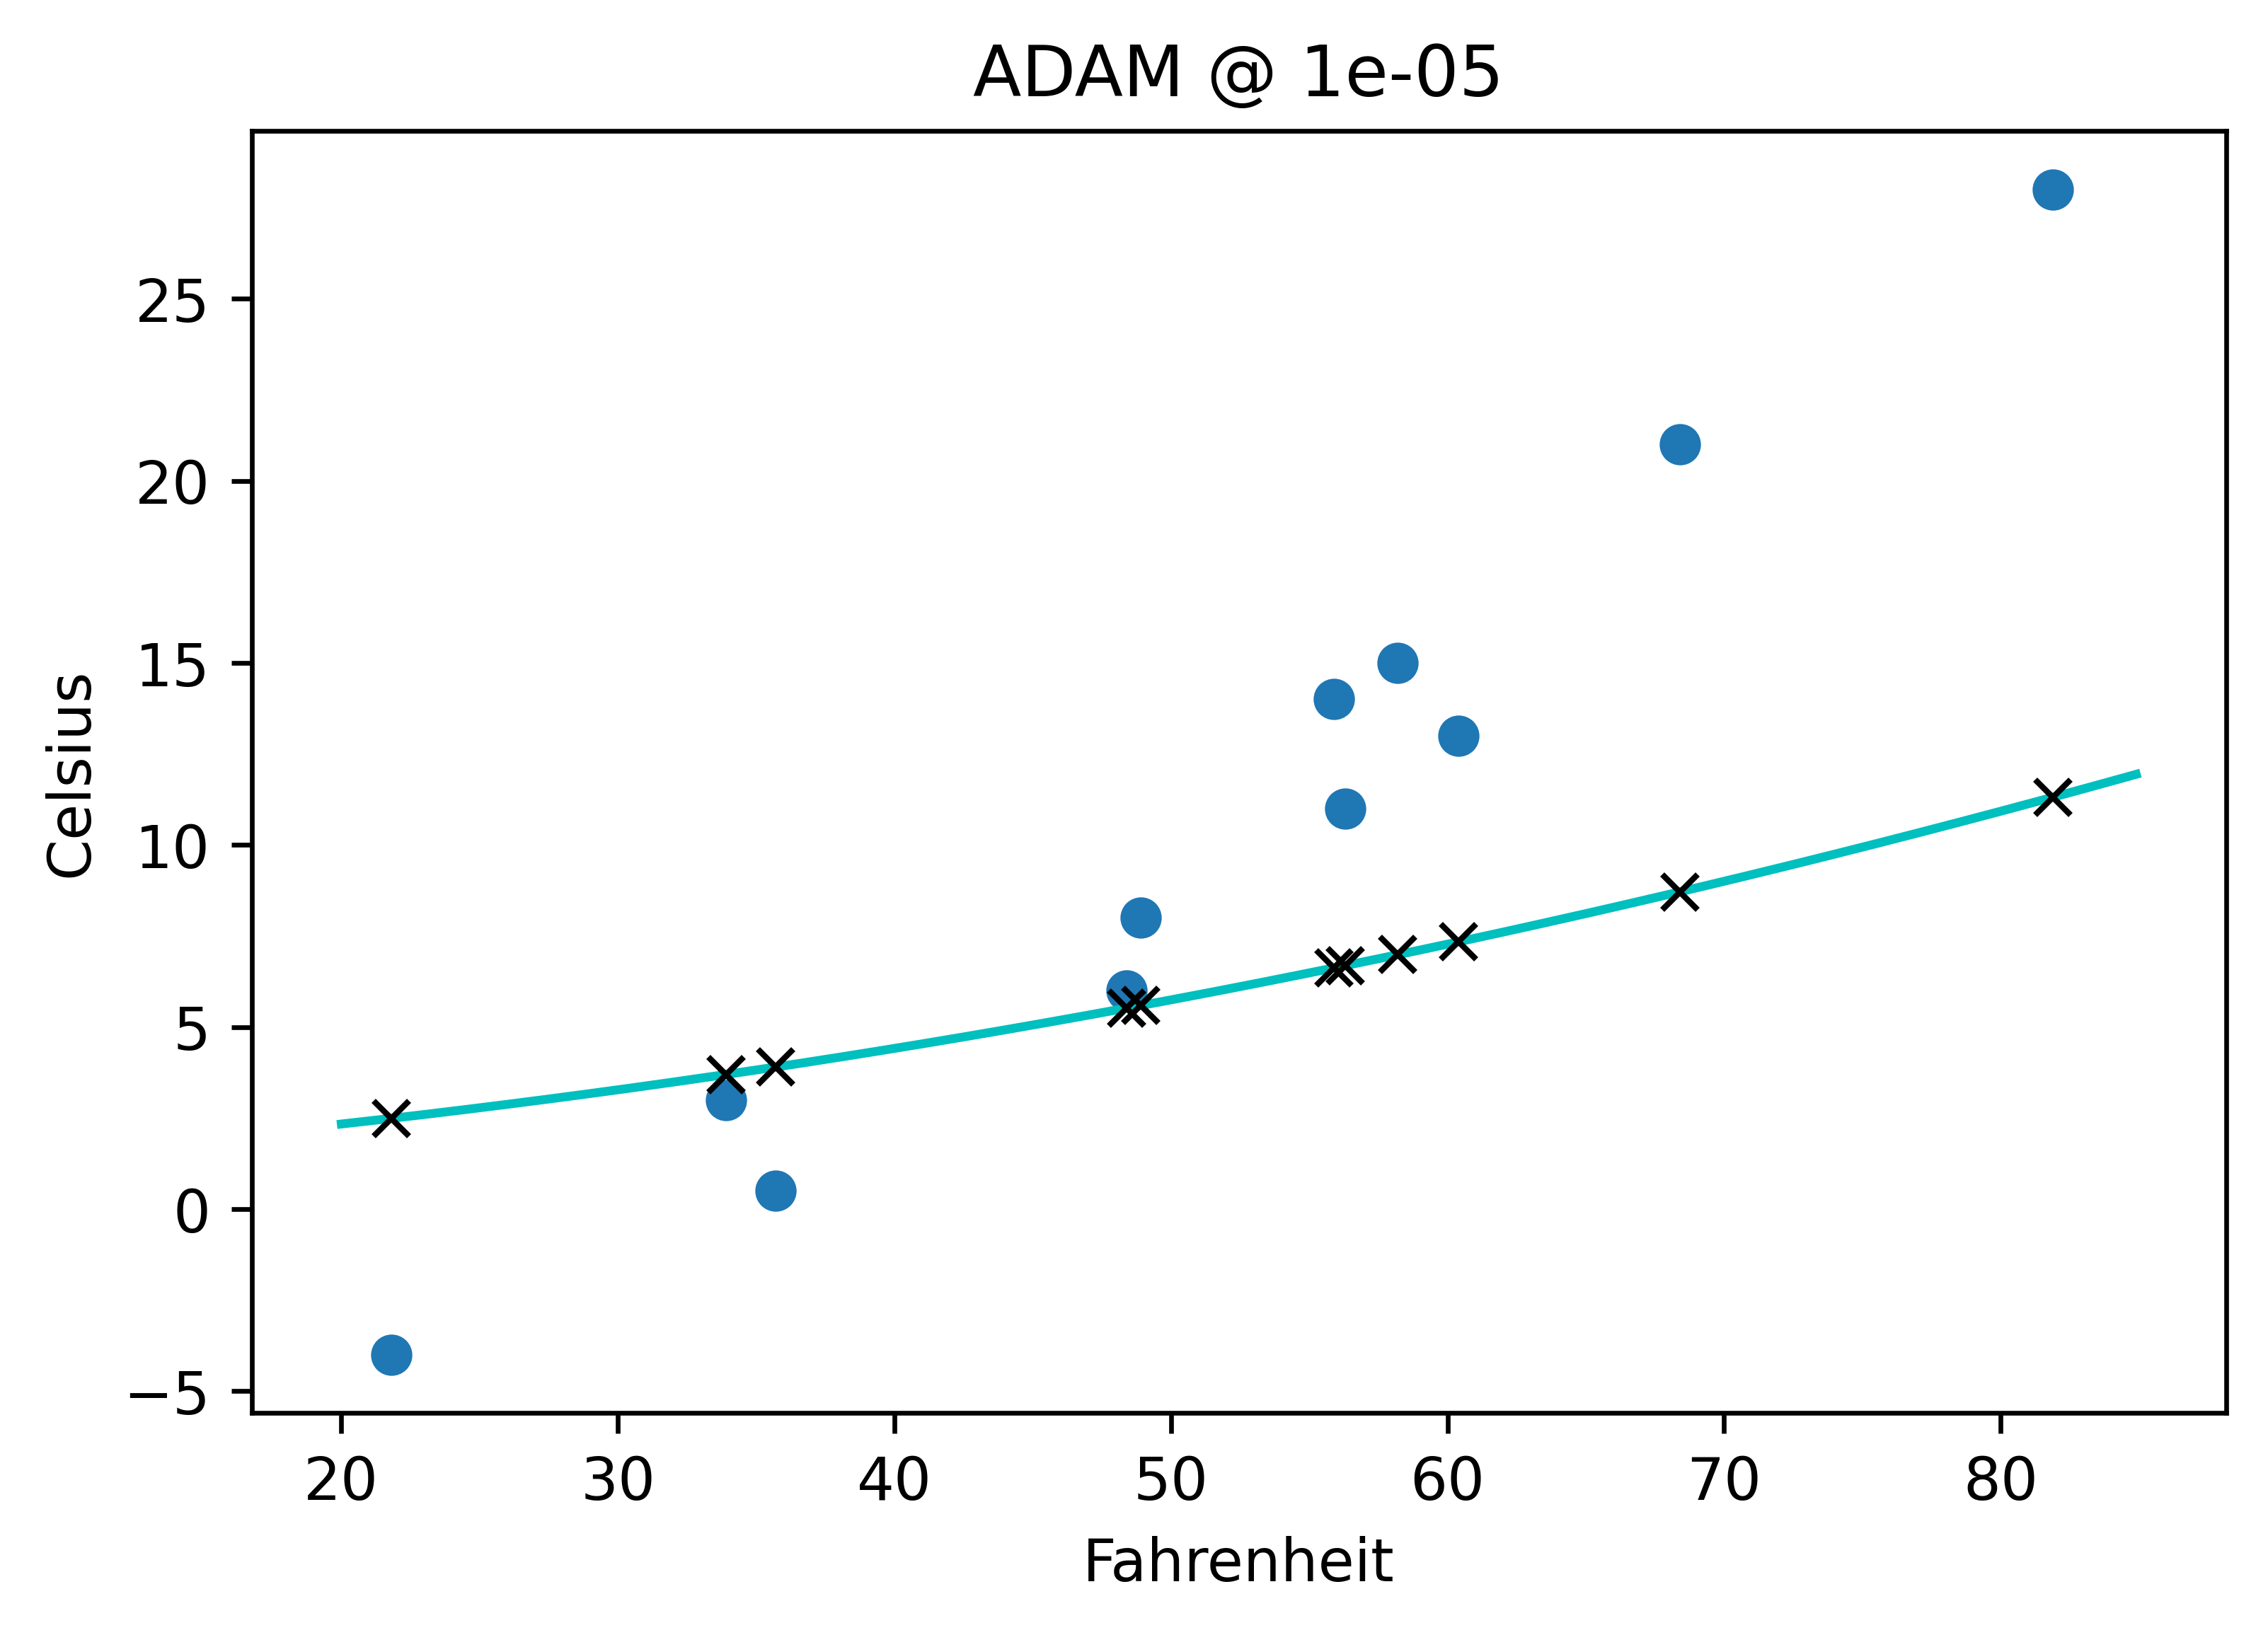

In [171]:
for rate in rates_to_learn_at:
    print(f"Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.Adam([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"ADAM @ {rate}")
    
    print('\n'+"--"*30+'\n')

### ADAGRAD

Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 3.6340394020080566
    Epoch 1000, Loss 3.2395477294921875
    Epoch 1500, Loss 3.169846534729004
    Epoch 2000, Loss 3.116138458251953
    Epoch 2500, Loss 3.065742254257202
    Epoch 3000, Loss 3.0179741382598877
    Epoch 3500, Loss 2.972666025161743
    Epoch 4000, Loss 2.929680109024048
    Epoch 4500, Loss 2.888887882232666
    Epoch 5000, Loss 2.85016131401062
Final Paramaters: tensor([ 0.5361, -0.2909, -3.6851], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 14.667835235595703
    Epoch 1000, Loss 13.528936386108398
    Epoch 1500, Loss 12.641729354858398
    Epoch 2000, Loss 11.894678115844727
    Epoch 2500, Loss 11.24638557434082
    Epoch 3000, Loss 10.673755645751953
    Epoch 3500, Loss 10.161916732788086
    Epoch 4000, Loss 9.70044994354248
    Epoch 4500, Loss 9.281635284423828
    Epoc

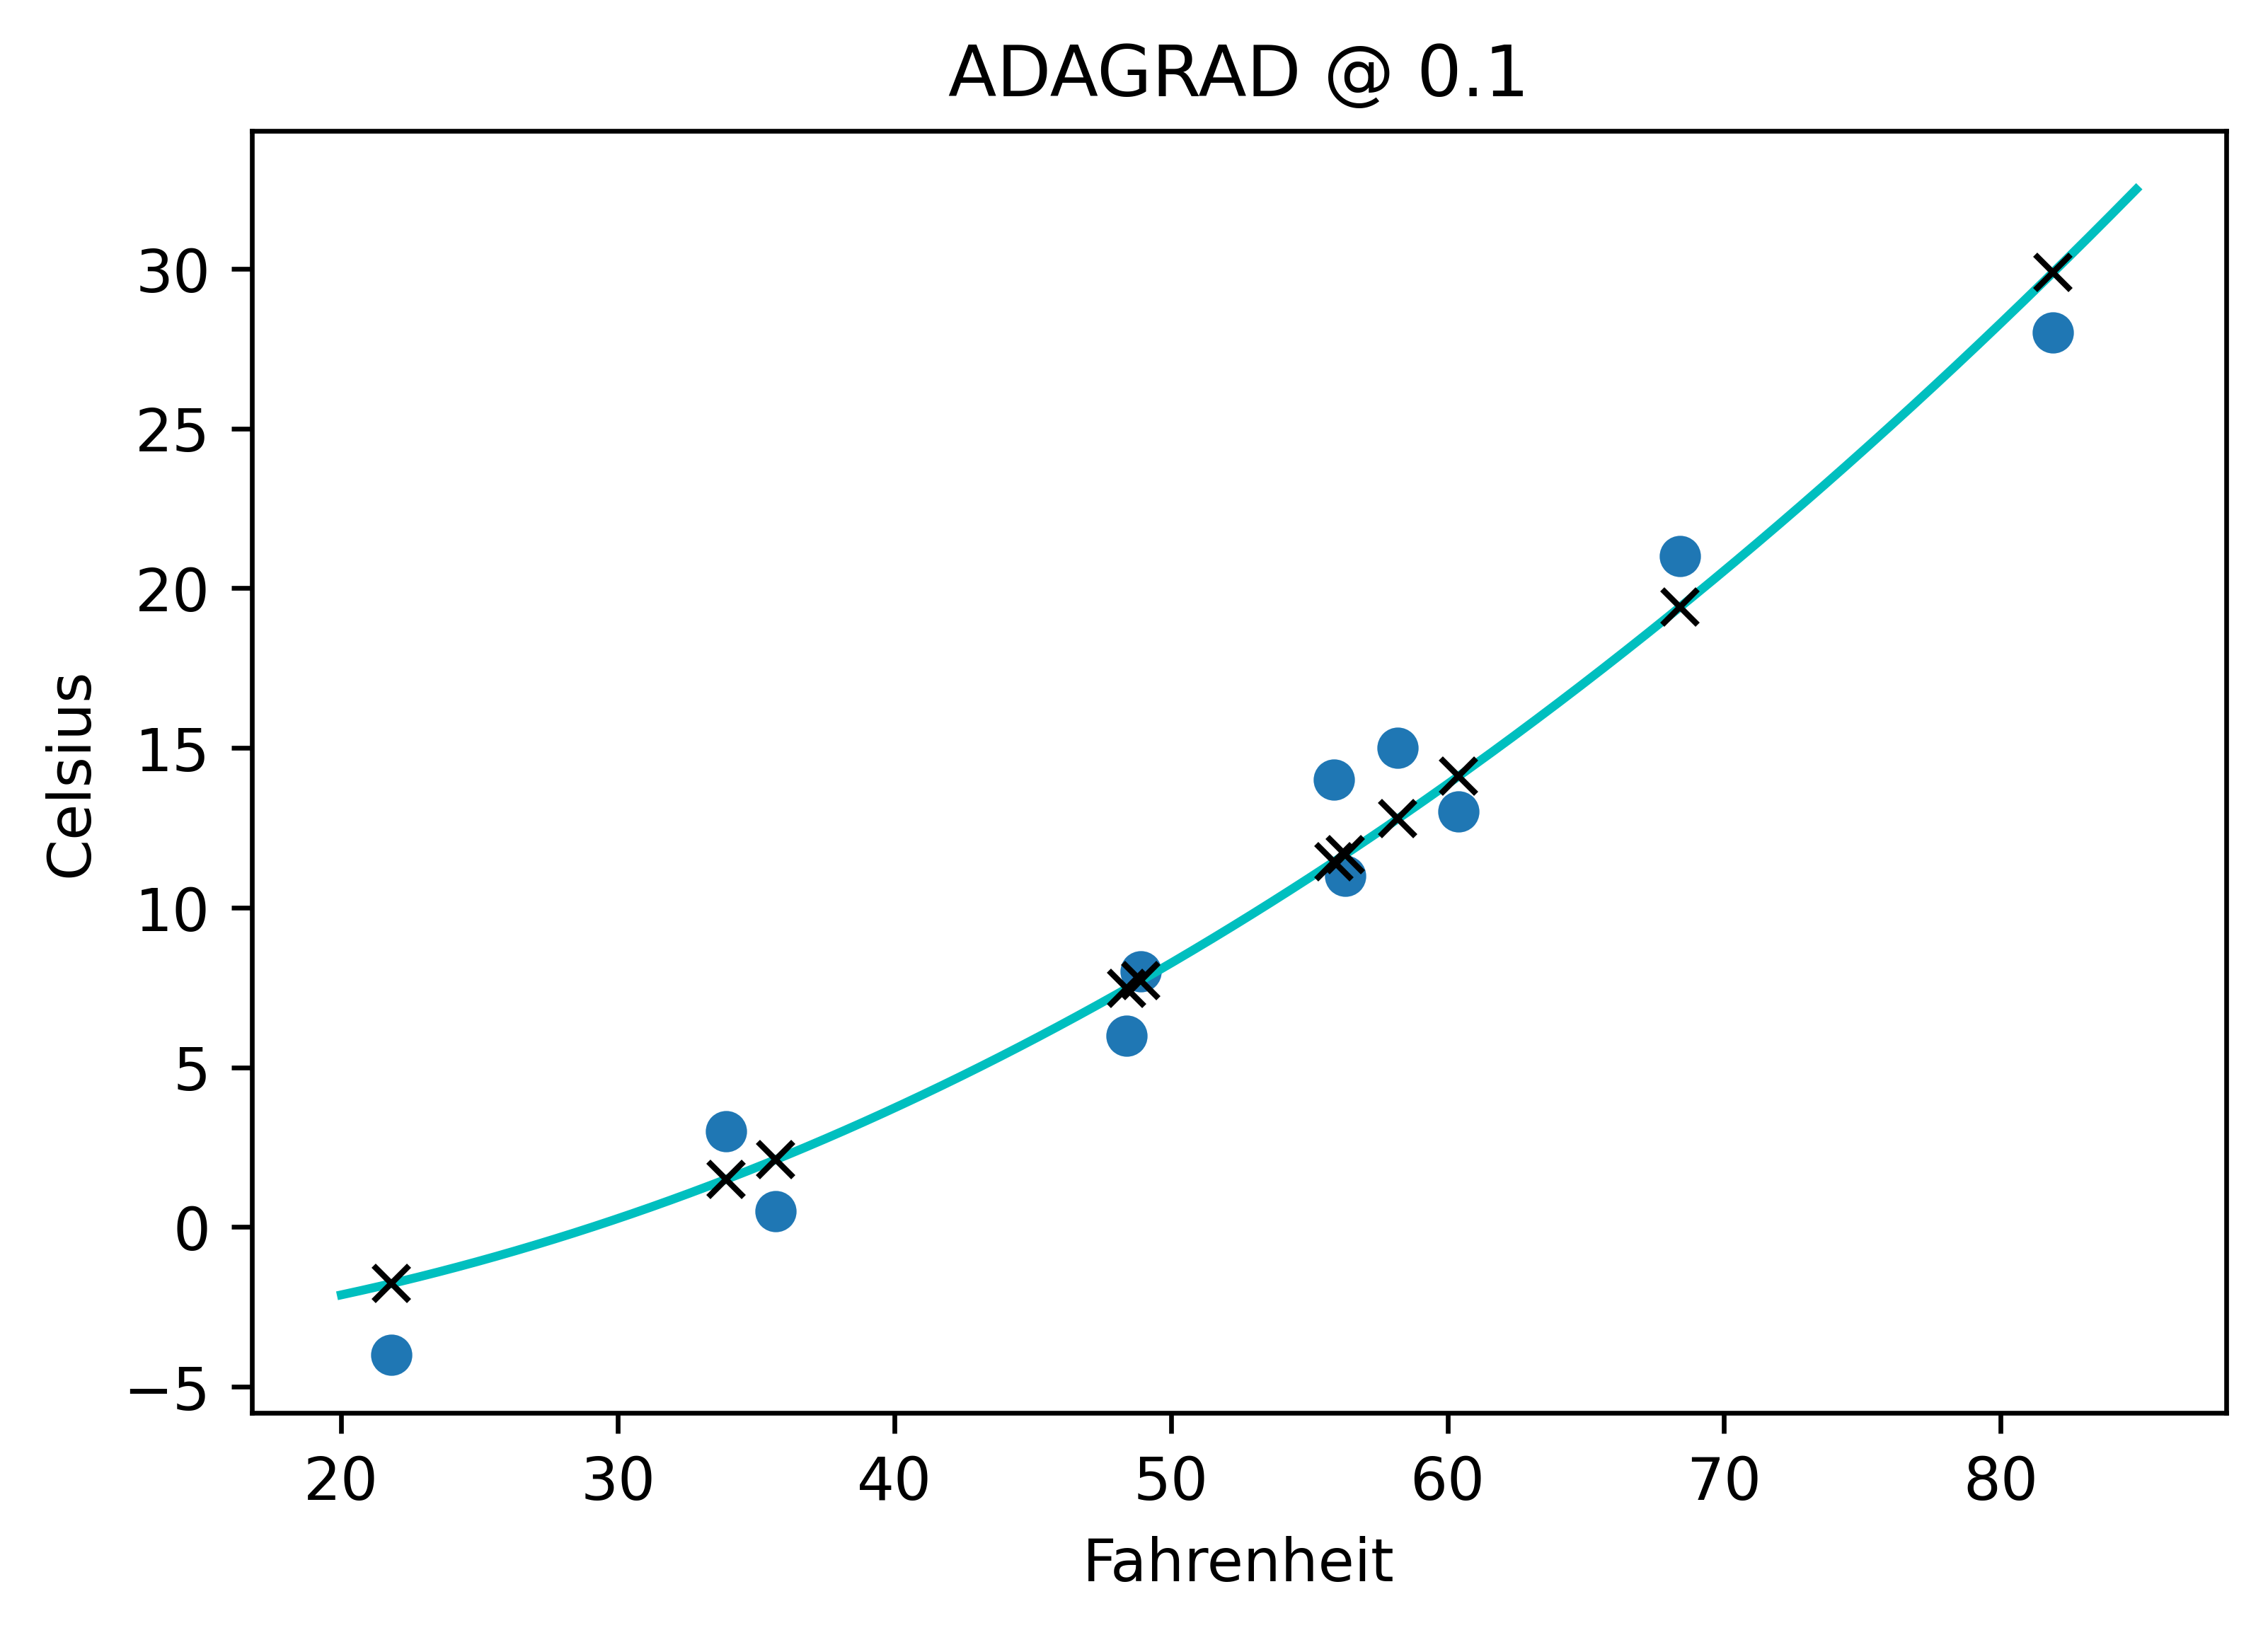

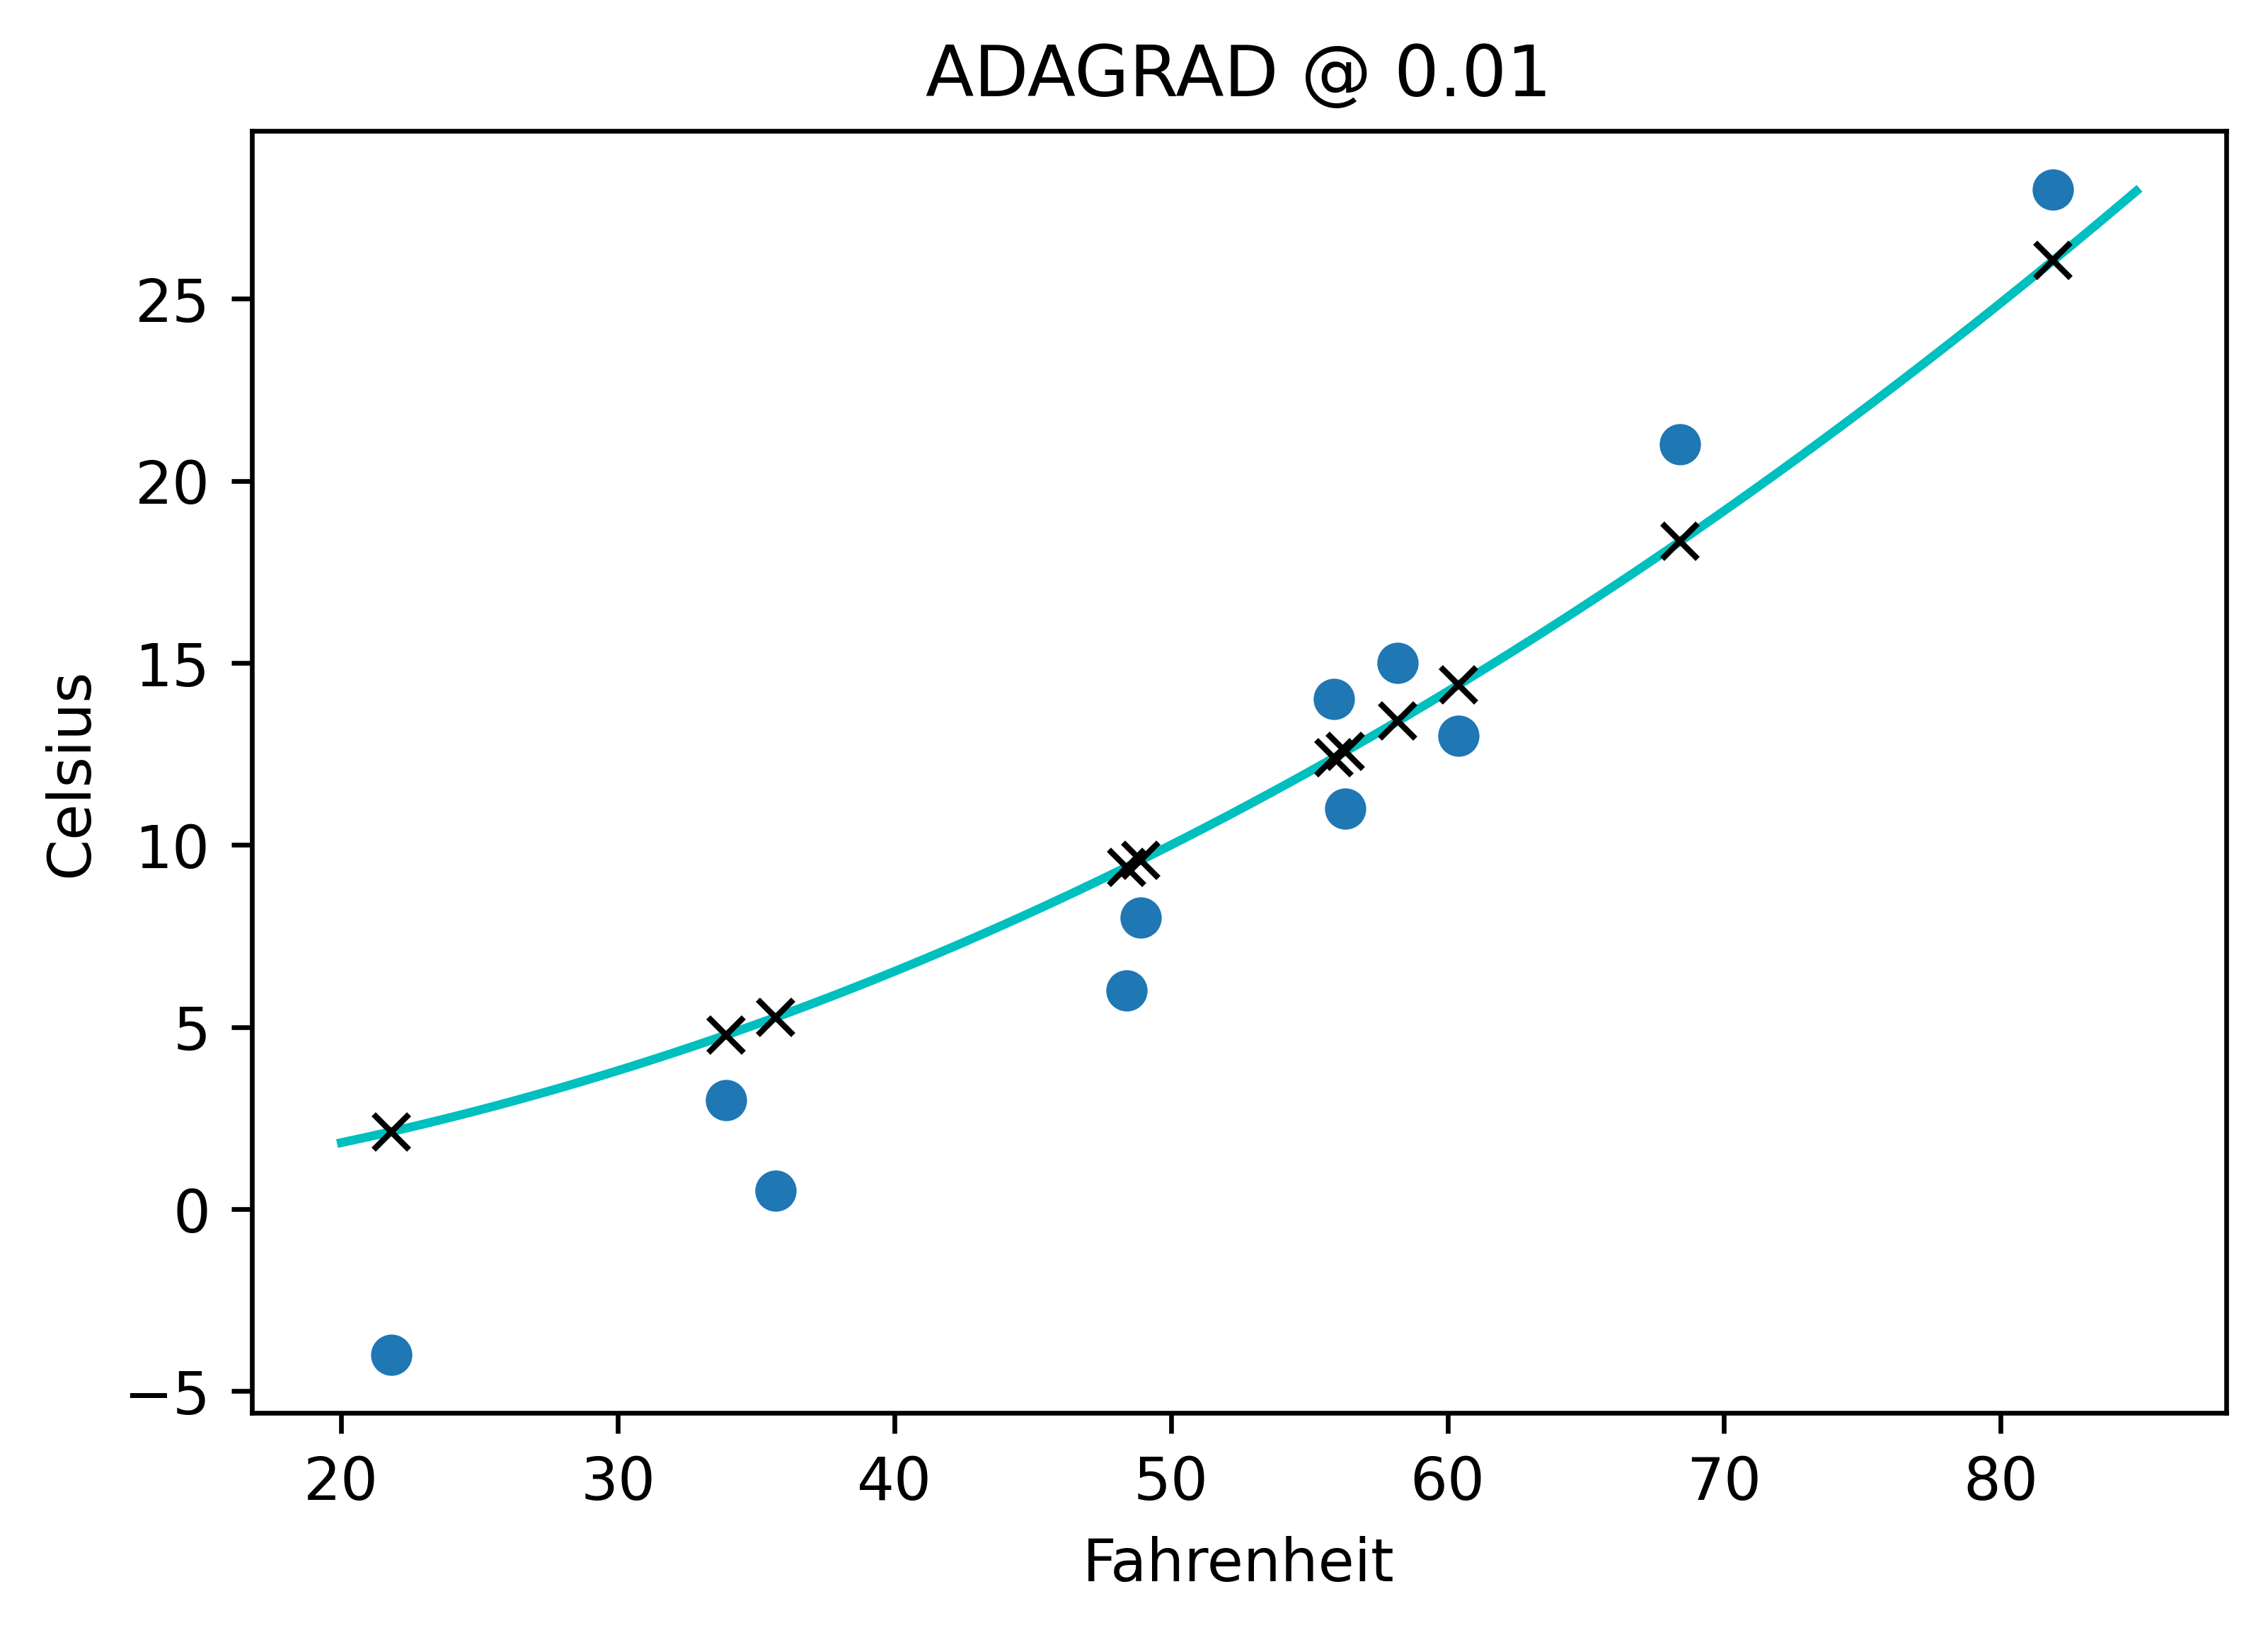

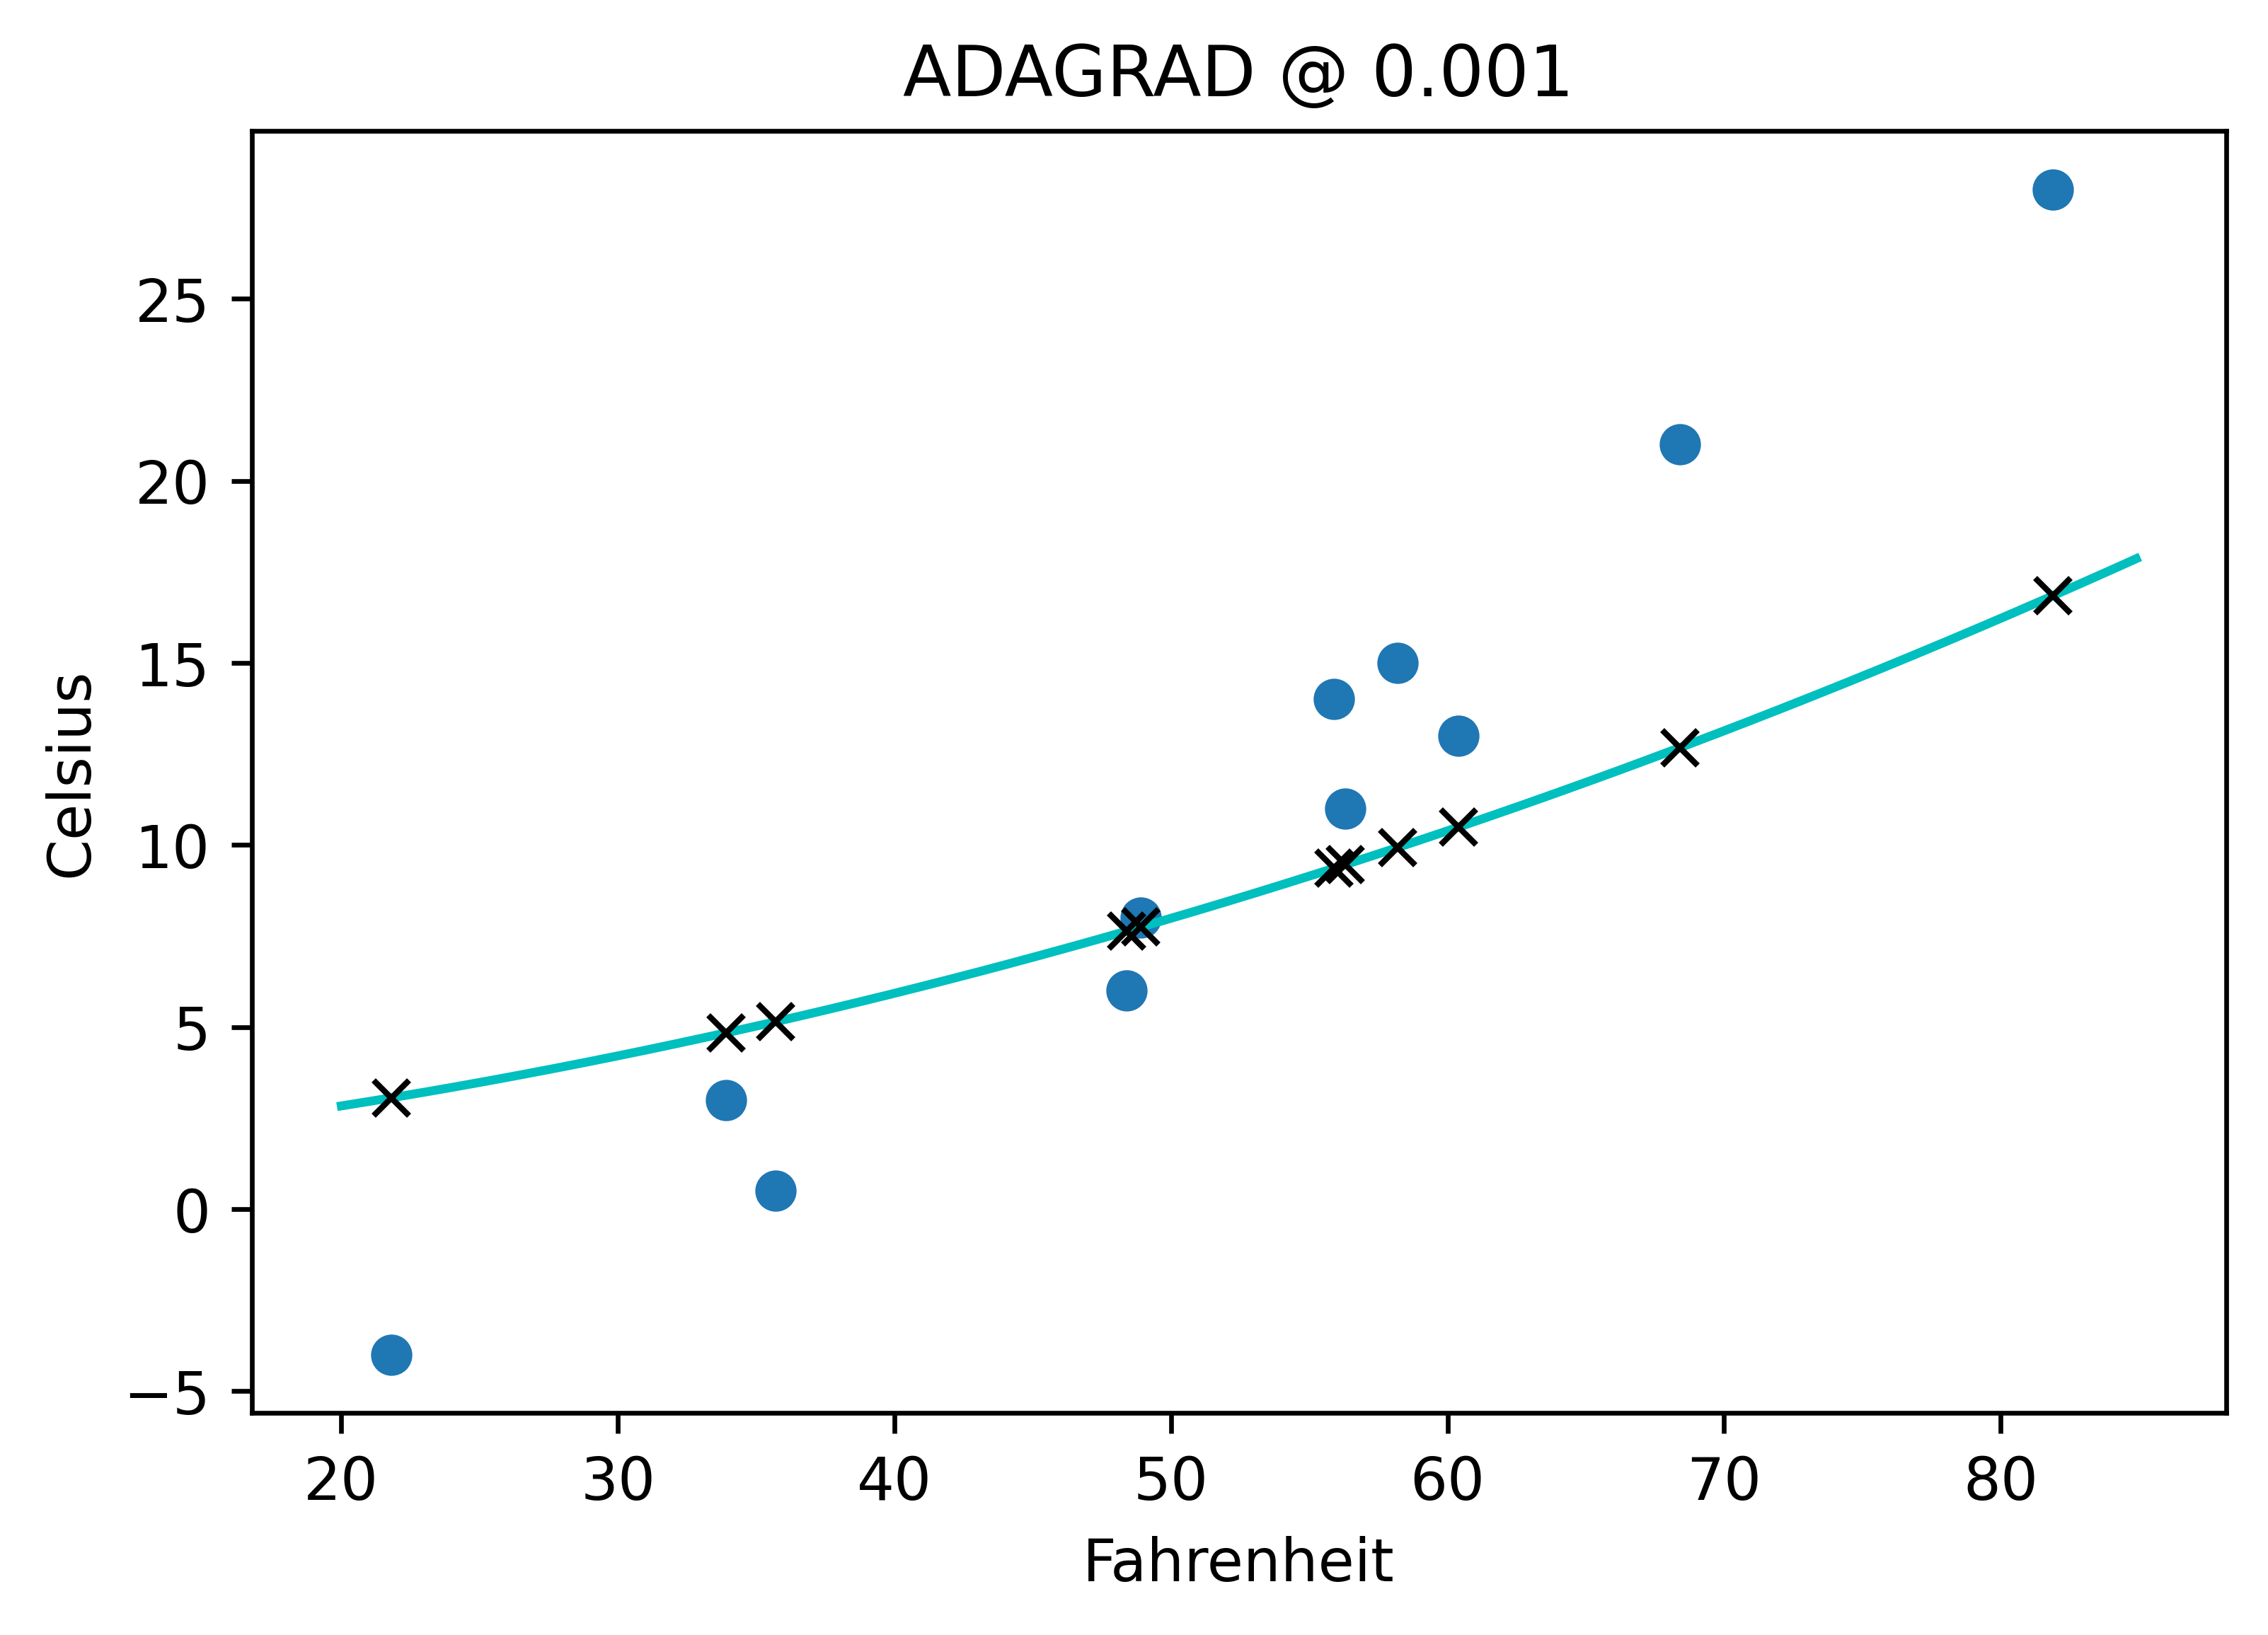

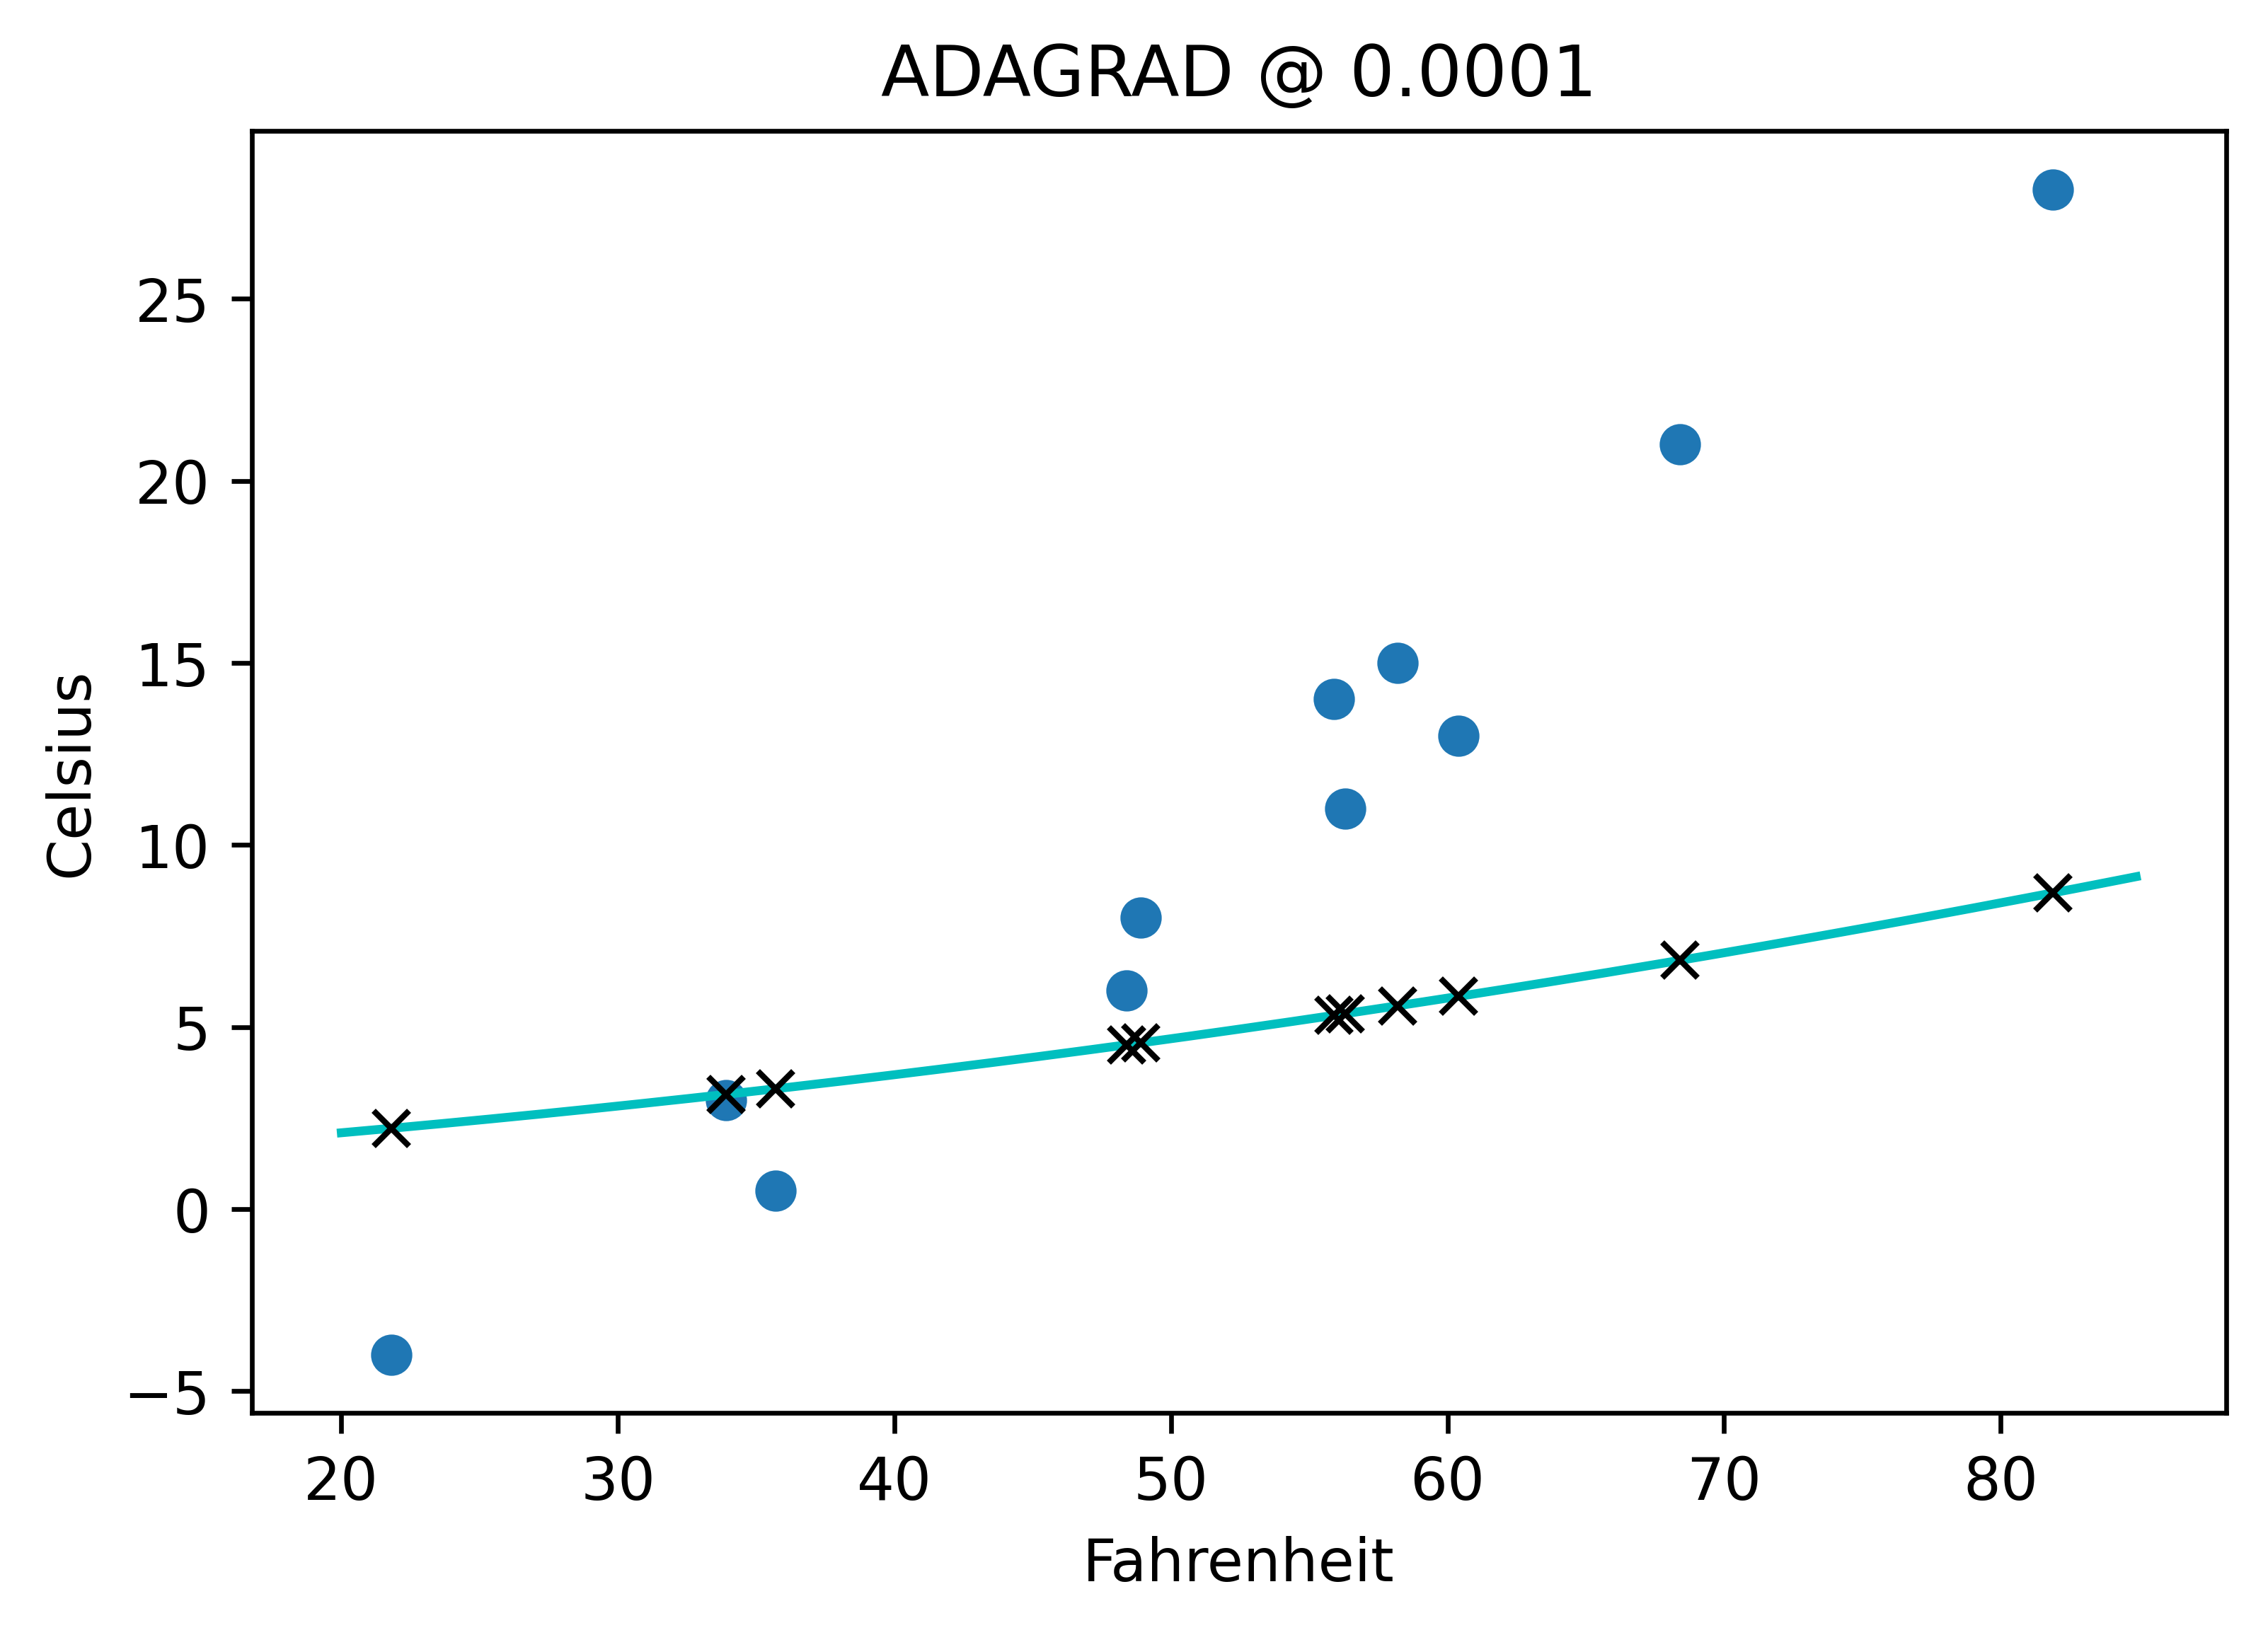

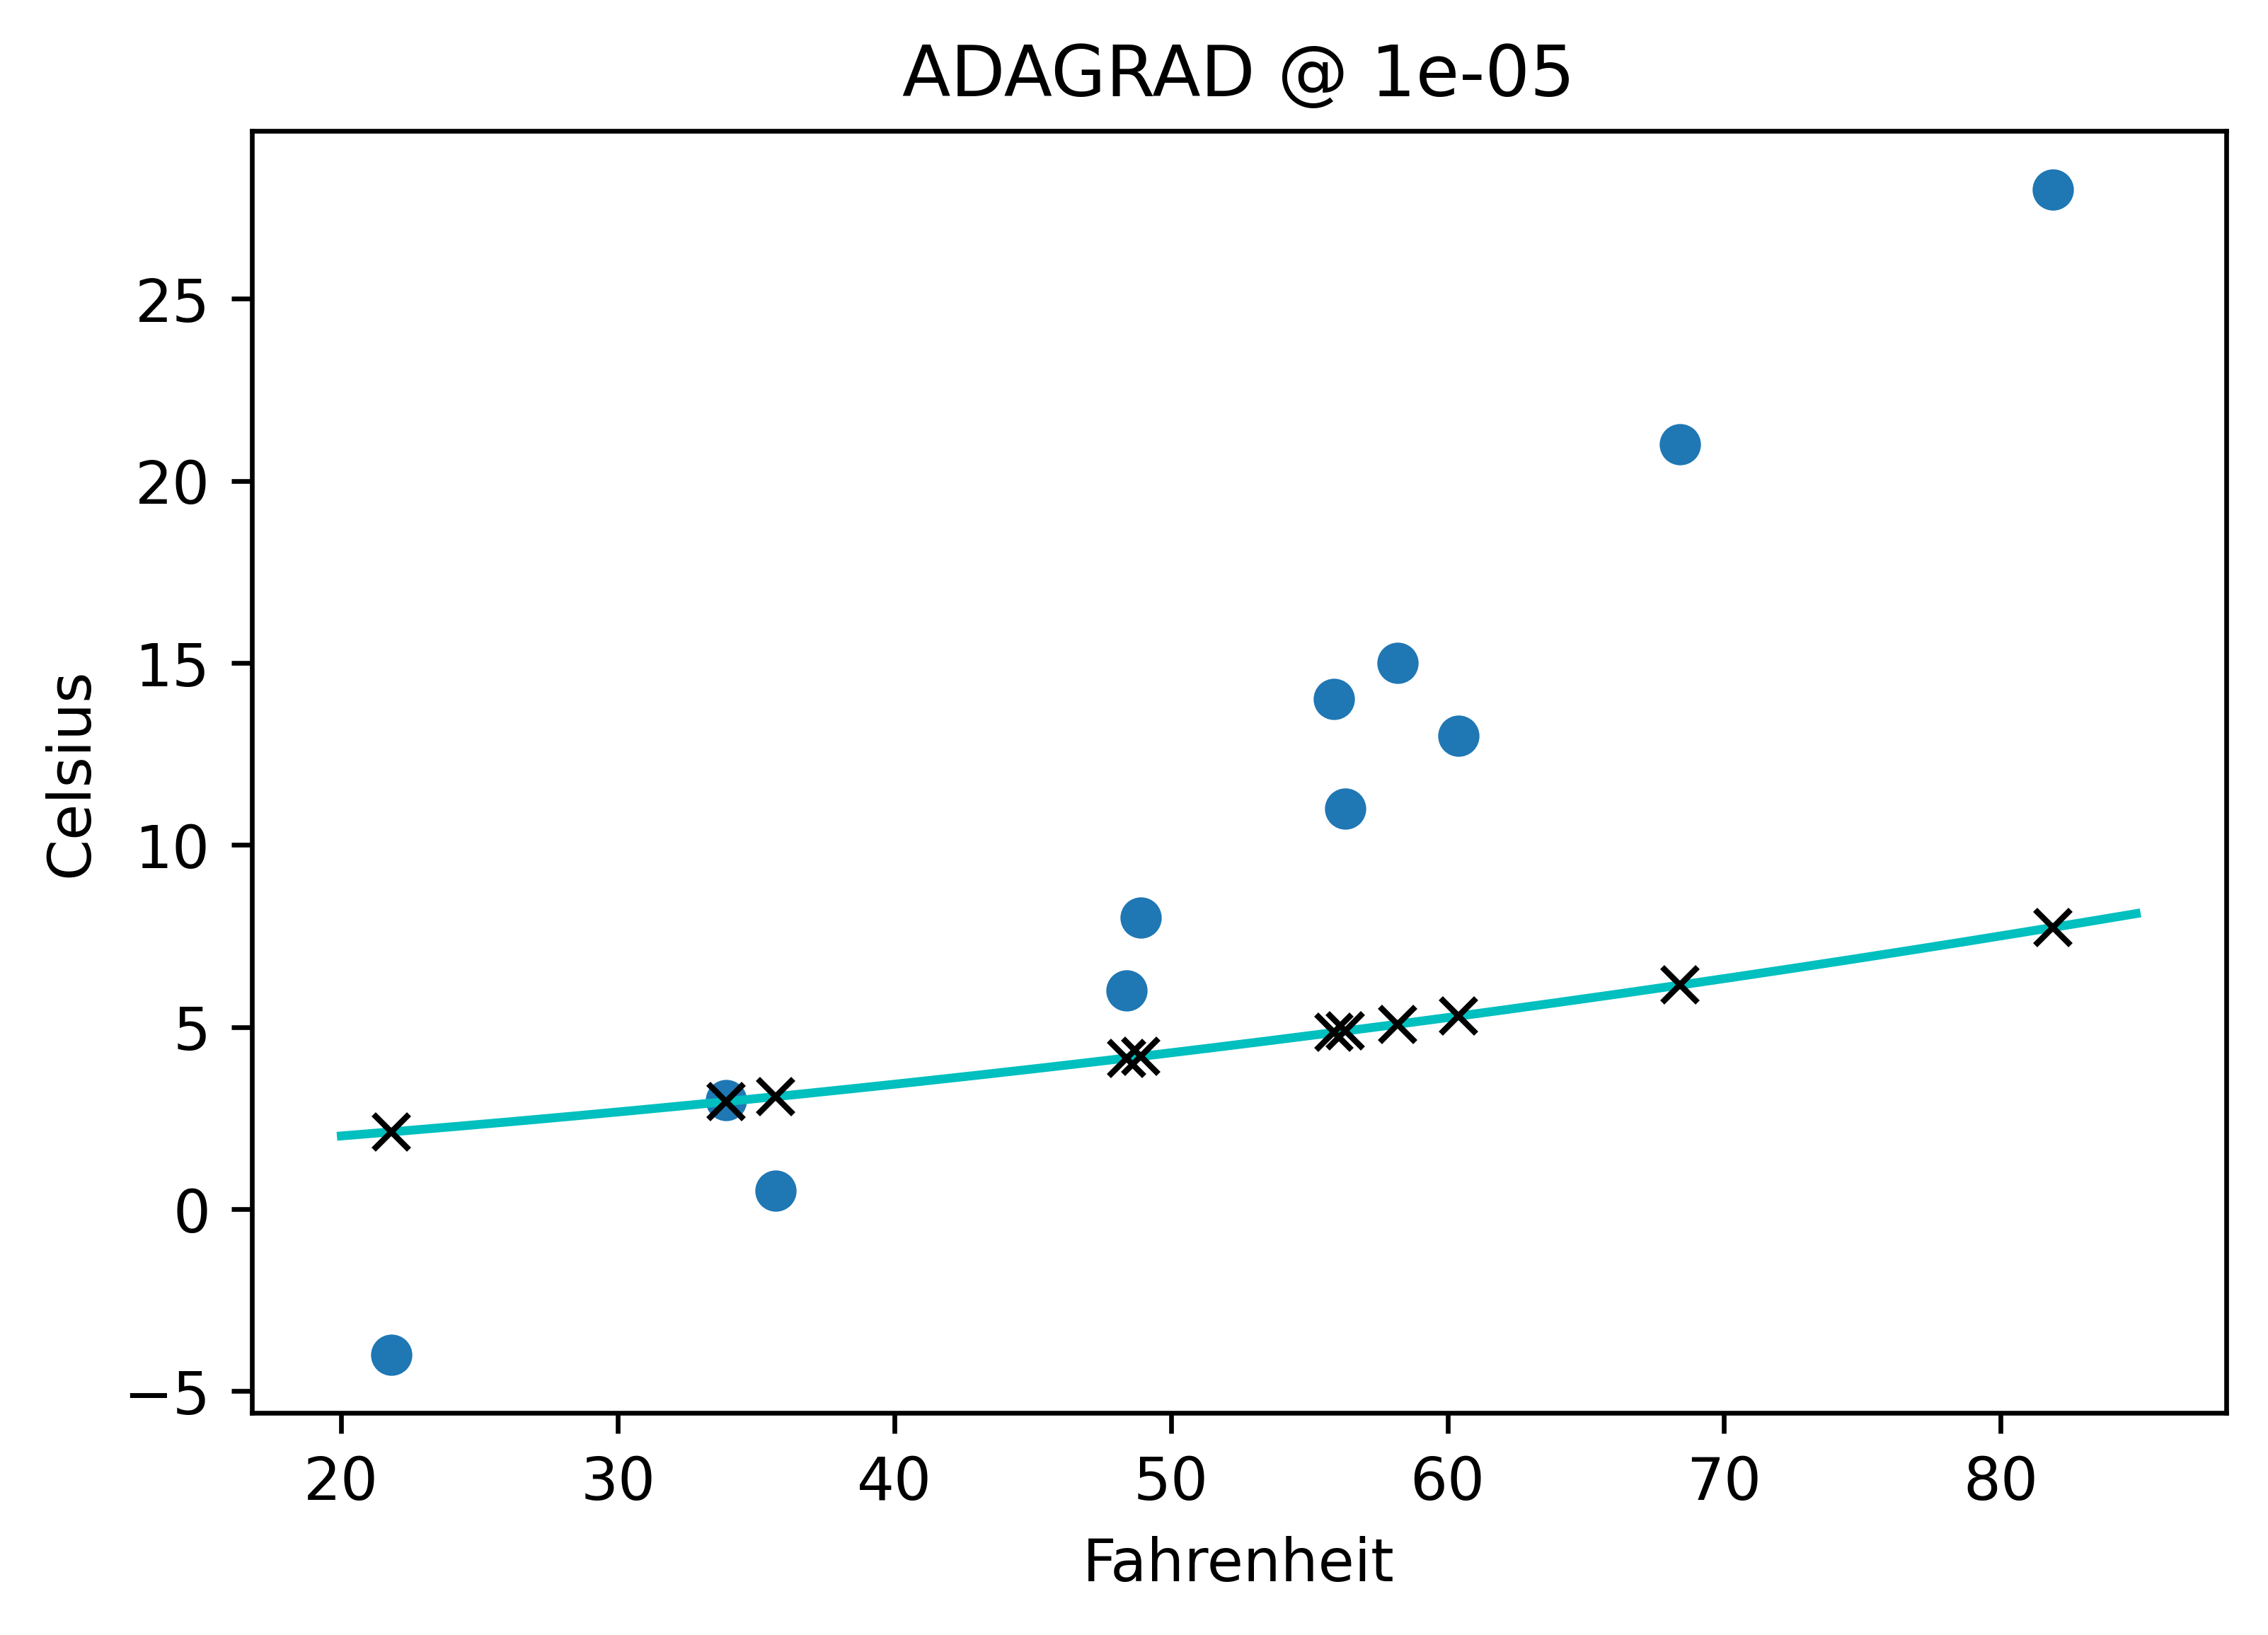

In [172]:
for rate in rates_to_learn_at:
    print(f"Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.Adagrad([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"ADAGRAD @ {rate}")
    
    print('\n'+"--"*30+'\n')

### ASGD

Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.001 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 200

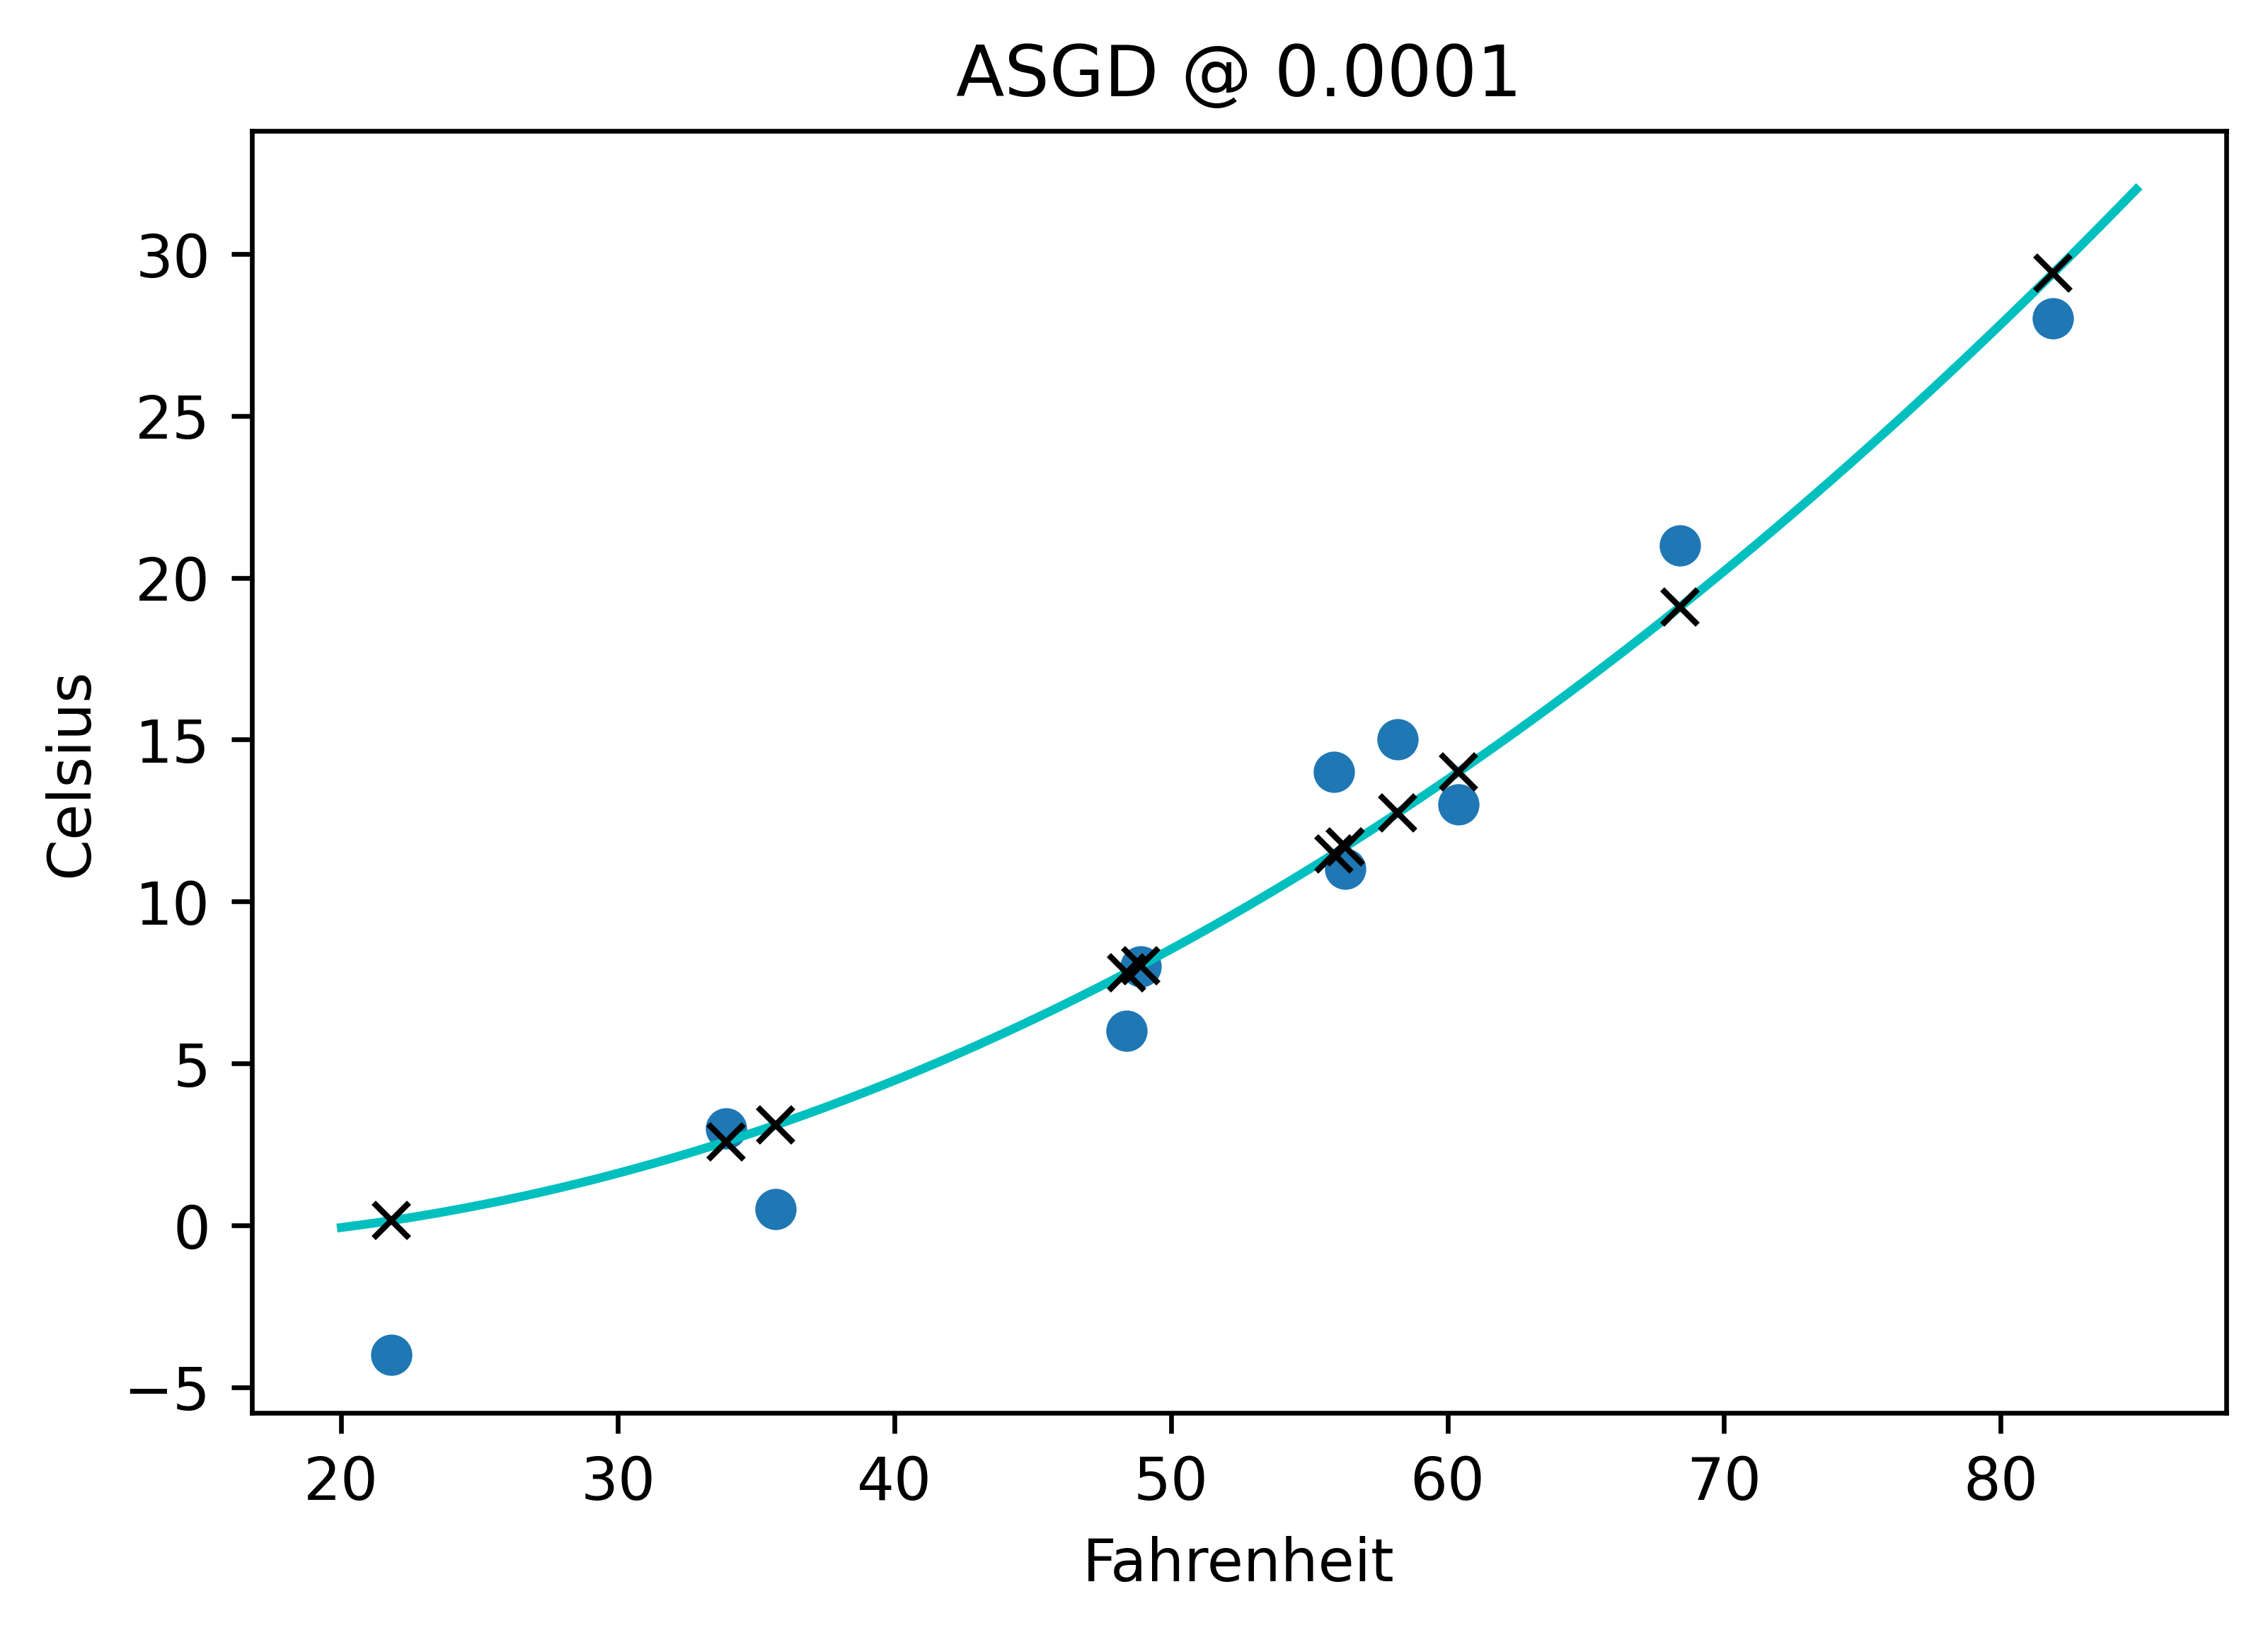

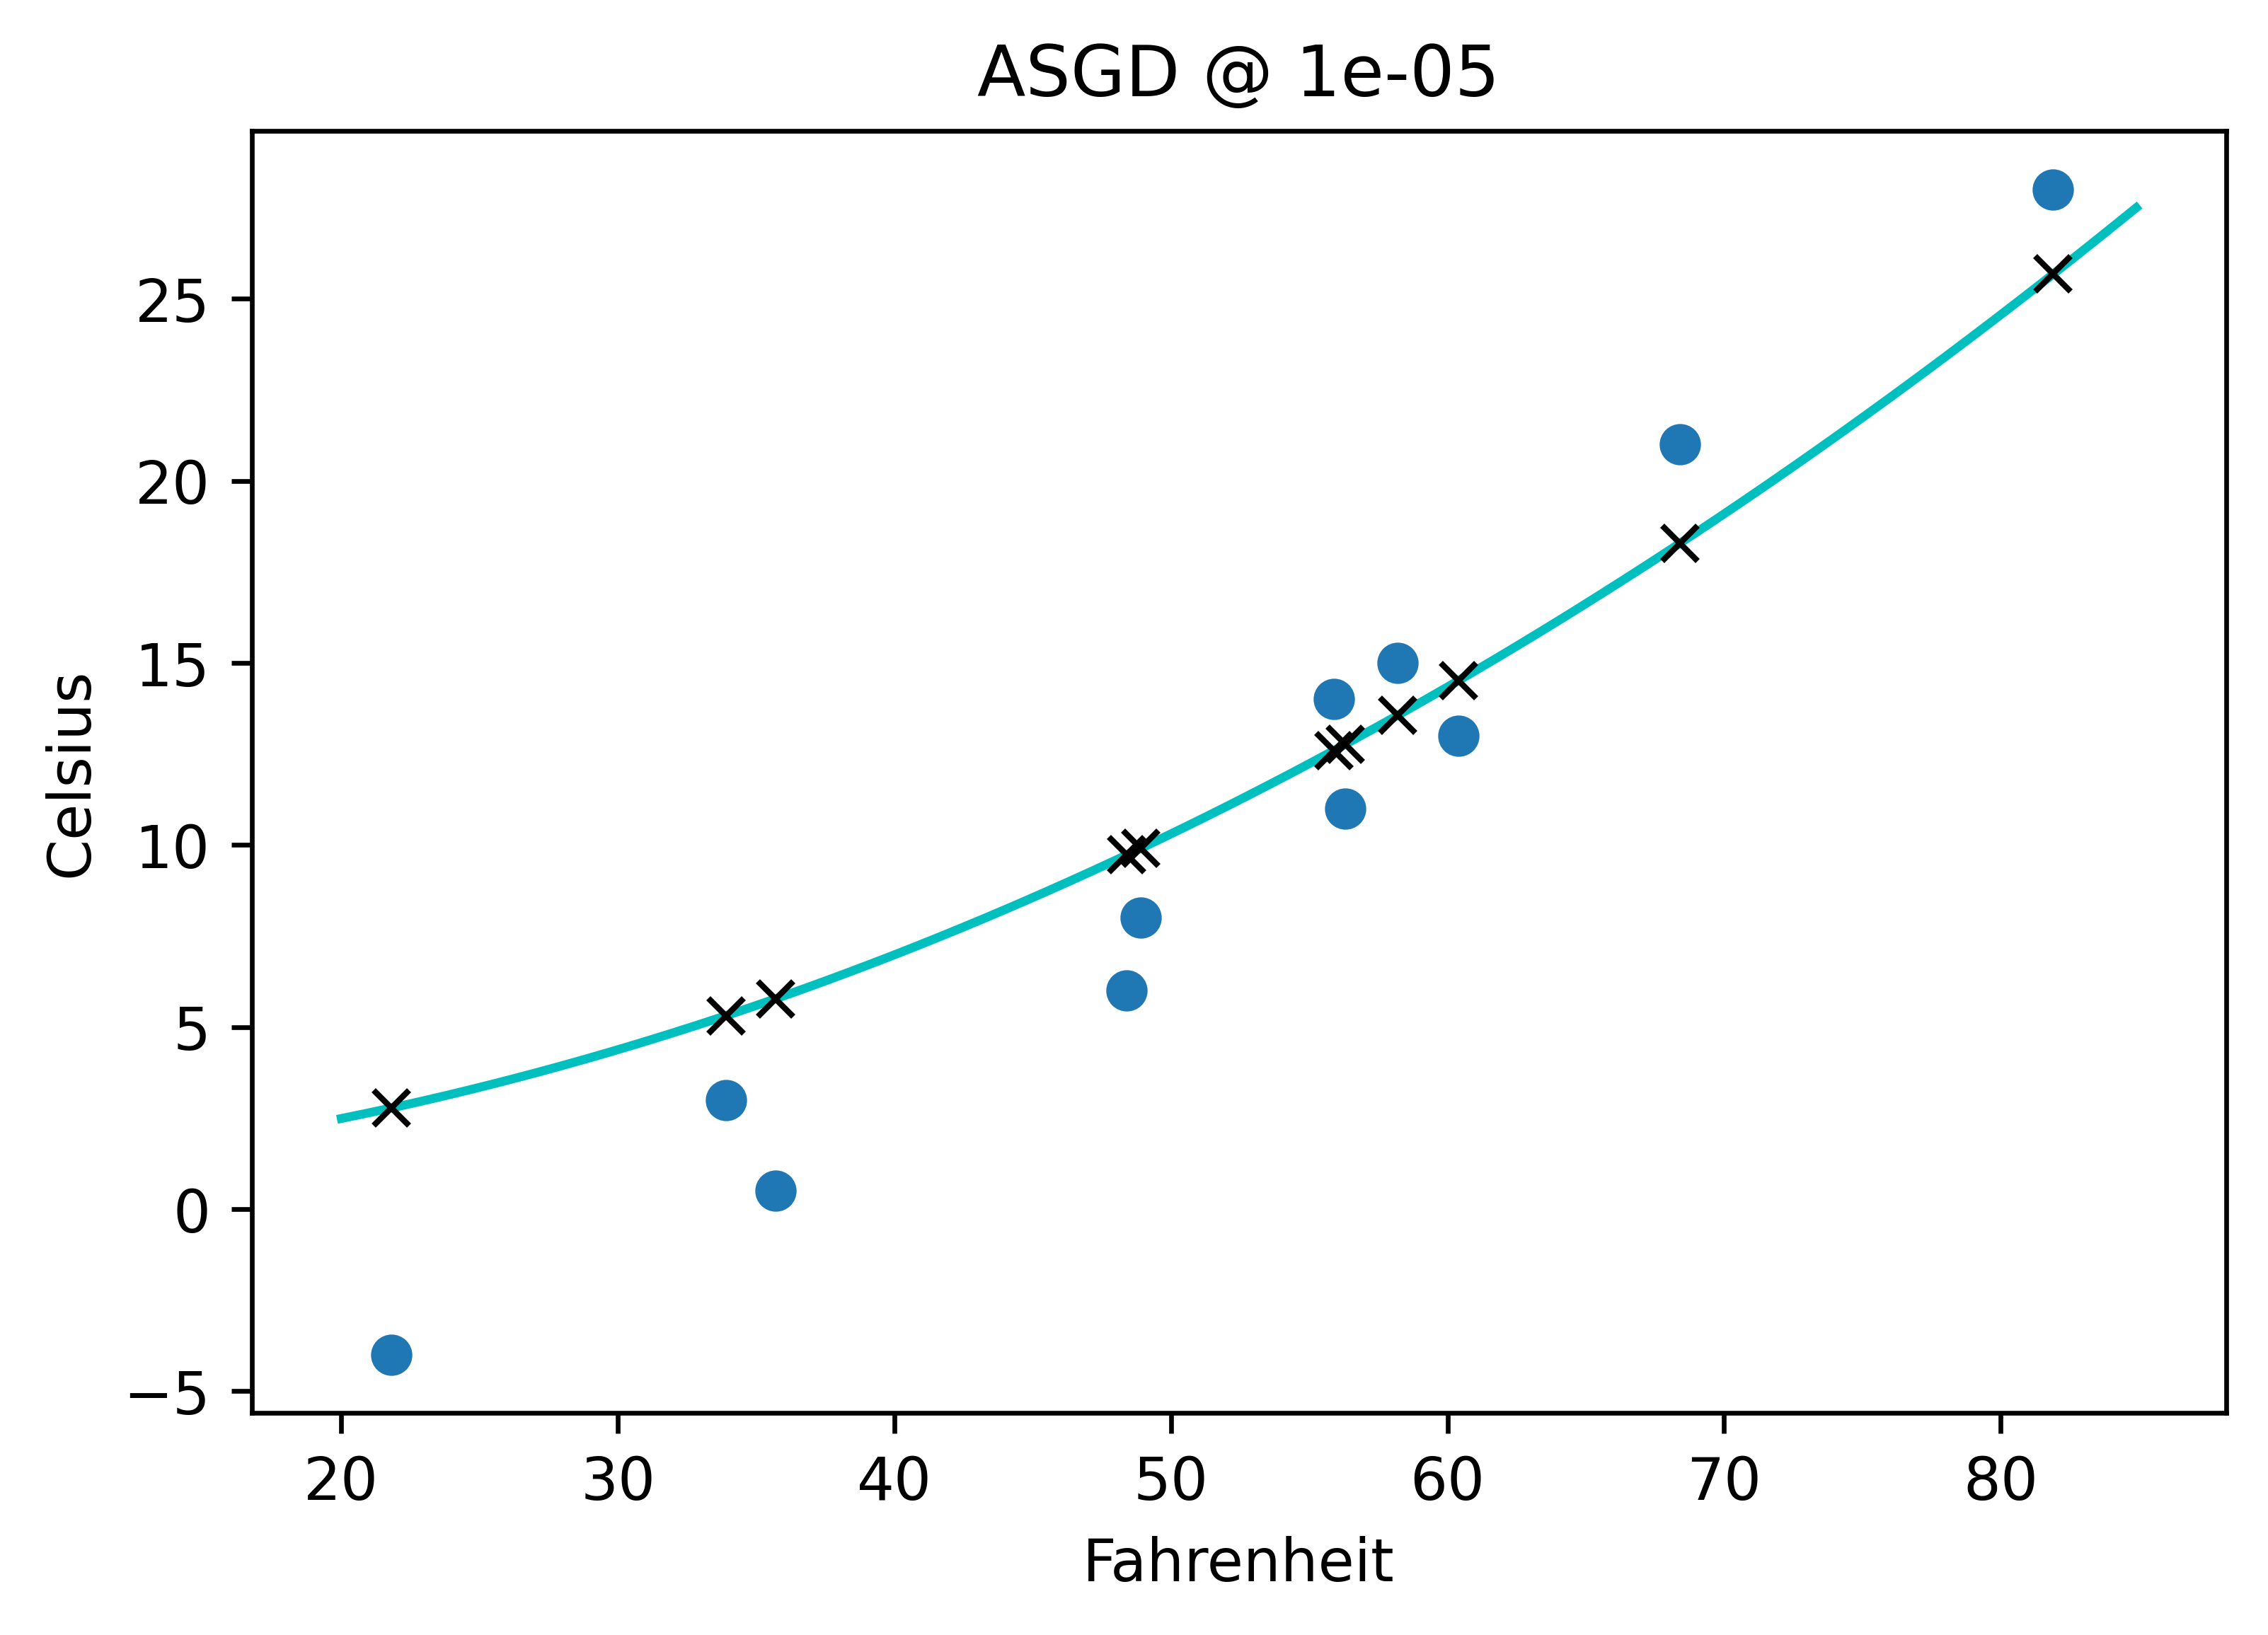

In [173]:
for rate in rates_to_learn_at:
    print(f"Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.ASGD([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"ASGD @ {rate}")
    
    print('\n'+"--"*30+'\n')